# 0. 트랜스포머로 한영 번역기 만들기

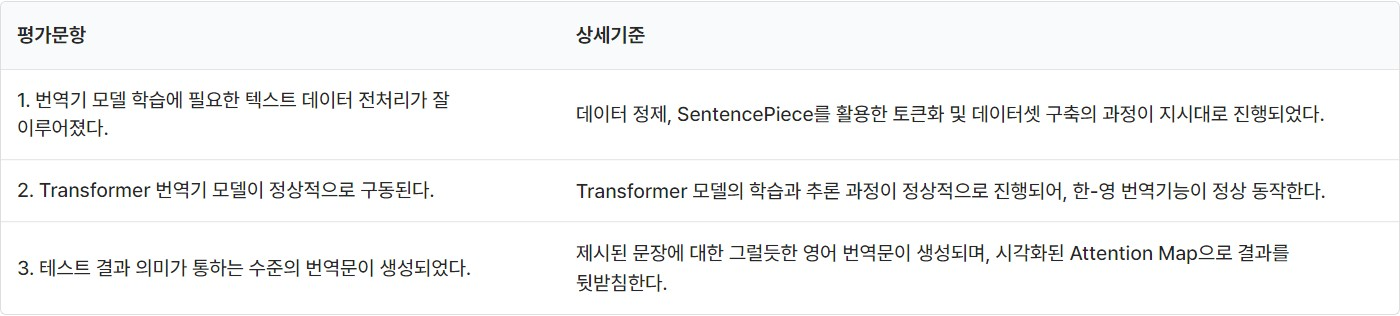

In [1]:
import re, os, io, time, random

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns

import sentencepiece as spm
from tqdm.notebook import tqdm
from tqdm import tqdm_notebook 

In [2]:
%config InlineBackend.figure_format = 'retina'

fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
fm.findfont(font)

'/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'

In [3]:
tf.random.set_seed(999)
np.random.seed(999)
random.seed(999)

# 1. 데이터 다운로드

https://github.com/jungyeul/korean-parallel-corpora/tree/master/korean-english-news-v1  
이 링크에서 korean-english-park.train.tar.gz 데이터를 사용할 것이다.

In [4]:
data_dir = os.getenv('HOME') + '/aiffel/transformer/data'
kor_path = data_dir + "/korean-english-park.train.ko"
eng_path = data_dir + "/korean-english-park.train.en"

# 2. 데이터 정제 및 토큰화

## 2.1. 중복 제거

In [5]:
# 데이터 정제 및 토큰화
def clean_corpus(kor_path, eng_path):
    with open(kor_path, "r") as f: kor = f.read().splitlines()
    with open(eng_path, "r") as f: eng = f.read().splitlines()
    assert len(kor) == len(eng)
    raw_corpus = pd.DataFrame(zip(kor, eng), columns=['kor', 'eng'])
    raw_corpus = raw_corpus.drop_duplicates('kor')
    raw_corpus = raw_corpus.drop_duplicates('eng')
    
    cleaned_corpus = []

    for k, e in raw_corpus.iloc:
        if ('://' in k) or ('://' in e):
            continue
        cleaned_corpus.append(f'{k}\t{e}')
        
    print('중복 제거 전 데이터 개수:', len(kor))
    print('중복 제거 후 데이터 개수:', len(cleaned_corpus))
    
    return cleaned_corpus

In [6]:
cleaned_corpus = clean_corpus(kor_path, eng_path)

중복 제거 전 데이터 개수: 94123
중복 제거 후 데이터 개수: 74699


In [7]:
cleaned_corpus[: 10]

['개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"\tMuch of personal computing is about "can you top this?"',
 '모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하지 않는다.\tso a mention a few weeks ago about a rechargeable wireless optical mouse brought in another rechargeable, wireless mouse.',
 "그러나 이것은 또한 책상도 필요로 하지 않는다.\tLike all optical mice, But it also doesn't need a desk.",
 '79.95달러하는 이 최첨단 무선 광마우스는 허공에서 팔목, 팔, 그외에 어떤 부분이든 그 움직임에따라 커서의 움직임을 조절하는 회전 운동 센서를 사용하고 있다.\tuses gyroscopic sensors to control the cursor movement as you move your wrist, arm, whatever through the air.',
 "정보 관리들은 동남 아시아에서의 선박들에 대한 많은 (테러) 계획들이 실패로 돌아갔음을 밝혔으며, 세계 해상 교역량의 거의 3분의 1을 운송하는 좁은 해로인 말라카 해협이 테러 공격을 당하기 쉽다고 경고하고 있다.\tIntelligence officials have revealed a spate of foiled plots on ships in Southeast Asia and are warning that a narrow stretch of water carrying almost one third of the world's maritime trade is vulnerable to a terror attack.",
 "이 지역에 있는 미국 선박과 상업용 선박들에 대한 알카에다의 (테러) 시도 중 여러 건이 실패했다는 것을 알게 된 후에, 전문가들은 테러

## 2.2. 데이터 정제

1. 모든 입력을 소문자로 변환한다.  
2. 알파벳, 문장부호, 한글만 남기고 모두 제거한다.  
3. 문장부호 양옆에 공백을 추가한다.  
4. 문장 앞뒤의 불필요한 공백을 제거한다.

In [8]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}


In [9]:
def preprocess_sentence(sentence):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split()]) # 약어 정규화
    sentence = re.sub(r"'s\b", "", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r"[^a-zA-Z가-힣0-9?.!,]+", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub(r"[' ']+", " ", sentence)
    sentence = sentence.strip()
    
    return sentence


In [10]:
preprocess_sentence(" #@45$ ?? she's 2 she'd D아( ?!    ㅁ94   ?마 ) roland's  a    Z4  3  ??  r ")

'45 ? ? she is 2 she would d아 roland a z4 3 ? ? r'

In [11]:
kor_corpus = []
eng_corpus = []

for pair in cleaned_corpus:
    k, e = pair.split("\t")

    kor_corpus.append(preprocess_sentence(k))
    eng_corpus.append(preprocess_sentence(e))
    
assert len(kor_corpus) == len(eng_corpus)

In [12]:
for i in range(10):
    print(">> ", kor_corpus[i])
    print(">> ", eng_corpus[i])
    print()

>>  개인용 컴퓨터 사용의 상당 부분은 이것보다 뛰어날 수 있느냐 ?
>>  much of personal computing is about can you top this ?

>>  모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하지 않는다 .
>>  so a mention a few weeks ago about a rechargeable wireless optical mouse brought in another rechargeable , wireless mouse .

>>  그러나 이것은 또한 책상도 필요로 하지 않는다 .
>>  like all optical mice , but it also does not need a desk .

>>  79 . 95달러하는 이 최첨단 무선 광마우스는 허공에서 팔목 , 팔 , 그외에 어떤 부분이든 그 움직임에따라 커서의 움직임을 조절하는 회전 운동 센서를 사용하고 있다 .
>>  uses gyroscopic sensors to control the cursor movement as you move your wrist , arm , whatever through the air .

>>  정보 관리들은 동남 아시아에서의 선박들에 대한 많은 계획들이 실패로 돌아갔음을 밝혔으며 , 세계 해상 교역량의 거의 3분의 1을 운송하는 좁은 해로인 말라카 해협이 테러 공격을 당하기 쉽다고 경고하고 있다 .
>>  intelligence officials have revealed a spate of foiled plots on ships in southeast asia and are warning that a narrow stretch of water carrying almost one third of the world maritime trade is vulnerable to a terror attack .

>>  이 지역에 있는 미국 선박과 상업용 선박들에 대한 알카에다의 시도 중 여러 건이 

## 2.3. 토큰화

한글 말뭉치 kor_corpus 와 영문 말뭉치 eng_corpus 를 각각 분리한 후, 정제하여 토큰화를 진행한다.  
토큰화에는 Sentencepiece를 활용하자. 아래 조건을 만족하는 generate_tokenizer() 함수를 정의한다.  
최종적으로 ko_tokenizer 과 en_tokenizer 를 얻자.  
en_tokenizer에는 set_encode_extra_options("bos:eos") 함수를 실행해 타겟 입력이 문장의 시작 토큰과 끝 토큰을 포함할 수 있게 하자.
1. 단어 사전을 매개변수로 받아 원하는 크기의 사전을 정의할 수 있게 한다.(기본: 20,000)  
2. 학습 후 저장된 model 파일을 SentencePieceProcessor() 클래스에 Load()한 후 반환한다.  
3. 특수 토큰의 인덱스를 아래와 동일하게 지정한다.  
\<PAD> : 0 / \<BOS> : 1 / \<EOS> : 2 / \<UNK> : 3

In [13]:
# Sentencepiece를 활용하여 학습한 tokenizer를 생성합니다.
def generate_tokenizer(corpus, vocab_size, lang="ko", pad_id=0, bos_id=1, eos_id=2,
                        unk_id=3):
    temp_file = f'korean-english-park.train.{lang}.temp'
    
    with open(temp_file, 'w') as f:
        for row in corpus:   # 이전 스텝에서 정제했던 corpus를 활용합니다.
            f.write(str(row) + '\n')
        
    spm.SentencePieceTrainer.Train(f'--input={temp_file} --model_prefix={lang}_spm'+
    f' --vocab_size={vocab_size} --pad_id={pad_id} --bos_id={bos_id}'+
    f' --eos_id={eos_id} --unk_id={unk_id}')
        
    tokenizer = spm.SentencePieceProcessor()
    tokenizer.Load(f'{lang}_spm.model')
        
    return tokenizer

In [14]:
SRC_VOCAB_SIZE = TGT_VOCAB_SIZE = 2 ** 14

ko_tokenizer = generate_tokenizer(kor_corpus, SRC_VOCAB_SIZE, "ko")
en_tokenizer = generate_tokenizer(eng_corpus, TGT_VOCAB_SIZE, "en")
en_tokenizer.set_encode_extra_options("bos:eos")

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=korean-english-park.train.ko.temp --model_prefix=ko_spm --vocab_size=16384 --pad_id=0 --bos_id=1 --eos_id=2 --unk_id=3
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: korean-english-park.train.ko.temp
  input_format: 
  model_prefix: ko_spm
  model_type: UNIGRAM
  vocab_size: 16384
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 3
  bos_id: 1
  eos_id: 2


True

 <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ⁇ 
}
normalizer_spec {
  name: nmt_nfkc
  add_dummy_prefix: 1
  remove_extra_whitespaces: 1
  escape_whitespaces: 1
  normalization_rule_tsv: 
}
denormalizer_spec {}
trainer_interface.cc(329) LOG(INFO) SentenceIterator is not specified. Using MultiFileSentenceIterator.
trainer_interface.cc(178) LOG(INFO) Loading corpus: korean-english-park.train.en.temp
trainer_interface.cc(385) LOG(INFO) Loaded all 74670 sentences
trainer_interface.cc(400) LOG(INFO) Adding meta_piece: <pad>
trainer_interface.cc(400) LOG(INFO) Adding meta_piece: <s>
trainer_interface.cc(400) LOG(INFO) Adding meta_piece: </s>
trainer_interface.cc(400) LOG(INFO) Adding meta_piece: <unk>
trainer_interface.cc(405) LOG(INFO) Normalizing sentences...
trainer_interface.cc(466) LOG(INFO) all chars count=10238795
trainer_interface.cc(477) LOG(INFO) Done: 99.9541% characters are covered.
trainer_interface.cc(487) LOG(INFO) Alphabet size=38
trainer_inter

## 2.4. 데이터 정제

토크나이저를 활용해 토큰의 길이가 50 이하인 데이터를 선별하여 src_corpus 와 tgt_corpus 를 각각 구축하고, 텐서 enc_train 과 dec_train 으로 변환하자.

In [15]:
src_corpus = []
tgt_corpus = []

min_len = 5
max_len = 50

# 토큰의 길이가 50 이하인 문장만 남깁니다. 
for idx in tqdm(range(len(kor_corpus))):
    ko_tokens = ko_tokenizer.EncodeAsIds(kor_corpus[idx])
    en_tokens = en_tokenizer.EncodeAsIds(eng_corpus[idx])
    
    if (min_len <= len(ko_tokens) <= max_len) and \
        (min_len+2 <= len(en_tokens) <= max_len):
        src_corpus.append(ko_tokens)
        tgt_corpus.append(en_tokens)    

# 패딩처리를 완료하여 학습용 데이터를 완성합니다. 
enc_train = tf.keras.preprocessing.sequence.pad_sequences(src_corpus, padding='post')
dec_train = tf.keras.preprocessing.sequence.pad_sequences(tgt_corpus, padding='post')

  0%|          | 0/74699 [00:00<?, ?it/s]

In [16]:
print(enc_train[0])
print(ko_tokenizer.SampleEncodeAsPieces(kor_corpus[0], 1, 0.0))
print(ko_tokenizer.DecodeIds(src_corpus[0]))

[ 1092   334   573   559     7  1437  1712     9  1284   233  2190   991
    28 10875   700     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0]
['▁개인', '용', '▁컴퓨터', '▁사용', '의', '▁상당', '▁부분', '은', '▁이것', '보다', '▁뛰어', '날', '▁수', '▁있느냐', '▁?']
개인용 컴퓨터 사용의 상당 부분은 이것보다 뛰어날 수 있느냐 ?


In [17]:
src_corpus[0]

[1092, 334, 573, 559, 7, 1437, 1712, 9, 1284, 233, 2190, 991, 28, 10875, 700]

In [18]:
print(dec_train[0])
print(en_tokenizer.SampleEncodeAsPieces(eng_corpus[0], 1, 0.0))
print(en_tokenizer.DecodeIds(tgt_corpus[0]))

[   1  350   11 1438 7244   14   21   56  118  104  262   51   15    3
    2    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]
['<s>', '▁much', '▁of', '▁personal', '▁comput', 'ing', '▁is', '▁about', '▁can', '▁you', '▁top', '▁this', '▁', '?', '</s>']
much of personal computing is about can you top this  ⁇ 


In [19]:
tgt_corpus[0]

[1, 350, 11, 1438, 7244, 14, 21, 56, 118, 104, 262, 51, 15, 3, 2]

# 3. 모델 설계

In [20]:
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, int(i) / d_model)

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])
    
    return sinusoid_table


In [21]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
            
        self.depth = d_model // self.num_heads
            
        self.W_q = tf.keras.layers.Dense(d_model)
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
            
        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        QK = tf.matmul(Q, K, transpose_b=True)

        scaled_qk = QK / tf.math.sqrt(d_k)

        if mask is not None: scaled_qk += (mask * -1e9)  

        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions
            
    def split_heads(self, x):
        batch_size = x.shape[0]
        split_x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])

        return split_x

    def combine_heads(self, x):
        batch_size = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (batch_size, -1, self.d_model))

        return combined_x
        
    def call(self, Q, K, V, mask):
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)
        
        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)
            
        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask)

        out = self.combine_heads(out)
        out = self.linear(out)
                
        return out, attention_weights

In [22]:
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.w_1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.w_2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.w_1(x)
        out = self.w_2(out)
            
        return out

In [23]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):

        """
        Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual
        
        return out, enc_attn

In [24]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
    
    def call(self, x, enc_out, causality_mask, padding_mask):
        """
        Masked Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.dropout(out)
        out += residual
        """
        Multi-Head Attention
        """
        residual = out
        out = self.norm_2(out)
        out, dec_enc_attn = self.enc_dec_attn(out, enc_out, enc_out, causality_mask)
        out = self.dropout(out)
        out += residual
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual

        return out, dec_attn, dec_enc_attn
    

In [25]:
class Encoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]
        
    def call(self, x, mask):
        out = x
    
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
        
        return out, enc_attns

In [26]:
class Decoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]
                            
                            
    def call(self, x, enc_out, causality_mask, padding_mask):
        out = x
    
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, causality_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

In [27]:
class Transformer(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    src_vocab_size,
                    tgt_vocab_size,
                    pos_len,
                    dropout=0.2,
                    shared=True):
        super(Transformer, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)

        self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
        self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.dropout = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared = shared

        if shared: self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    def embedding(self, emb, x):
        seq_len = x.shape[1]
        out = emb(x)

        if self.shared: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.dropout(out)

        return out

    def call(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask):
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)
        
        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, causality_mask, dec_mask)
        
        logits = self.fc(dec_out)
        
        return logits, enc_attns, dec_attns, dec_enc_attns

In [28]:
def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    
    return seq[:, tf.newaxis, tf.newaxis, :]

In [29]:
def generate_causality_mask(src_len, tgt_len):
    mask = 1 - np.cumsum(np.eye(src_len, tgt_len), 0)
    
    return tf.cast(mask, tf.float32)

In [30]:
def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_mask = generate_padding_mask(tgt)

    dec_enc_causality_mask = generate_causality_mask(tgt.shape[1], src.shape[1])
    dec_enc_mask = tf.maximum(enc_mask, dec_enc_causality_mask)

    dec_causality_mask = generate_causality_mask(tgt.shape[1], tgt.shape[1])
    dec_mask = tf.maximum(dec_mask, dec_causality_mask)

    return enc_mask, dec_enc_mask, dec_mask


# 4. 훈련하기

## 4.1. Transformer 인스턴스 생성

In [31]:
n_layers = 2
d_model = 2 ** 8
n_heads = 2 ** 3
d_ff = 2 ** 10
dropout = 0.5

transformer = Transformer(n_layers=n_layers,
                          d_model=d_model,
                          n_heads=n_heads,
                          d_ff=d_ff,
                          src_vocab_size=SRC_VOCAB_SIZE,
                          tgt_vocab_size=TGT_VOCAB_SIZE,
                          pos_len=max_len,
                          dropout=dropout)

## 4.2. LearningRateScheduler

In [32]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)
    

In [33]:
warmup_steps = 2 ** 12

learning_rate = LearningRateScheduler(d_model=d_model,
                                      warmup_steps=warmup_steps)
optimizer = tf.keras.optimizers.Adam(learning_rate,
                                     beta_2=0.98, 
                                     epsilon=1e-9)

## 4.3. Loss

In [34]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [35]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    # Masking 되지 않은 입력의 개수로 Scaling하는 과정
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

## 4.4. train_step

train_step 함수를 정의하자.  
입력 데이터에 알맞은 Mask를 생성하고, 이를 모델에 전달하여 연산에서 사용할 수 있게 하자.

In [36]:
# Train Step 함수 정의
@tf.function()
def train_step(src, tgt, model, optimizer):
    gold = tgt[:, 1:]
        
    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt)

    # 계산된 loss에 tf.GradientTape()를 적용해 학습을 진행합니다.
    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(src, tgt, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions[:, :-1])

    # 최종적으로 optimizer.apply_gradients()가 사용됩니다. 
    batch_loss = (loss / int(tgt.shape[1]))

    variables = model.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return loss, enc_attns, dec_attns, dec_enc_attns

## 4.5. 학습 진행

매 Epoch 마다 제시된 예문에 대한 번역을 생성하도록 하자.

In [37]:
# Attention 시각화 함수
def visualize_attention(src, tgt, enc_attns, dec_attns, dec_enc_attns):
    def draw(data, ax, x="auto", y="auto"):
        sns.heatmap(data, 
                        square=True,
                        vmin=0.0, vmax=1.0, 
                        cbar=False, ax=ax,
                        xticklabels=x,
                        yticklabels=y)
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Encoder Layer", layer + 1)
        for h in range(4):
            draw(enc_attns[layer][0, h, :len(src), :len(src)], axs[h], src, src)
        plt.show()
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Decoder Self Layer", layer+1)
        for h in range(4):
            draw(dec_attns[layer][0, h, :len(tgt), :len(tgt)], axs[h], tgt, tgt)
        plt.show()

        print("Decoder Src Layer", layer+1)
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        for h in range(4):
            draw(dec_enc_attns[layer][0, h, :len(tgt), :len(src)], axs[h], src, tgt)
        plt.show()
        

In [38]:
# 번역 생성 함수
def evaluate(sentence, model, src_tokenizer, tgt_tokenizer):
    sentence = preprocess_sentence(sentence)

    pieces = src_tokenizer.encode_as_pieces(sentence)
    tokens = src_tokenizer.encode_as_ids(sentence)

    _input = tf.keras.preprocessing.sequence.pad_sequences([tokens],
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')
    
    ids = []
    output = tf.expand_dims([tgt_tokenizer.bos_id()], 0)
    for i in range(dec_train.shape[-1]):
        enc_padding_mask, combined_mask, dec_padding_mask = \
        generate_masks(_input, output)

        predictions, enc_attns, dec_attns, dec_enc_attns =\
        model(_input, 
              output,
              enc_padding_mask,
              combined_mask,
              dec_padding_mask)

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()

        if tgt_tokenizer.eos_id() == predicted_id:
            result = tgt_tokenizer.decode_ids(ids)
            return pieces, result, enc_attns, dec_attns, dec_enc_attns

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)

    result = tgt_tokenizer.decode_ids(ids)

    return pieces, result, enc_attns, dec_attns, dec_enc_attns


In [39]:
# 번역 생성 및 Attention 시각화 결합
def translate(sentence, model, src_tokenizer, tgt_tokenizer, plot_attention=False):
    pieces, result, enc_attns, dec_attns, dec_enc_attns = \
    evaluate(sentence, model, src_tokenizer, tgt_tokenizer)
    
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    if plot_attention:
        visualize_attention(pieces, result.split(), enc_attns, dec_attns, dec_enc_attns)


In [40]:
# 학습
BATCH_SIZE = 2 ** 5
EPOCHS = 2 ** 3

examples = [
            "오바마는 대통령이다.",
            "시민들은 도시 속에 산다.",
            "커피는 필요 없다.",
            "일곱 명의 사망자가 발생했다."
]

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm_notebook(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(enc_train[idx:idx+BATCH_SIZE],
                    dec_train[idx:idx+BATCH_SIZE],
                    transformer,
                    optimizer)

        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))

    for example in examples:
        translate(example, transformer, ko_tokenizer, en_tokenizer)

/tmp/ipykernel_7064/1478024037.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm_notebook(idx_list)


  0%|          | 0/2099 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president of the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: the storm was the deadly .
Input: 커피는 필요 없다.
Predicted translation: it is the first time .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the quake was killed at least two people .


  0%|          | 0/2099 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the obama .
Input: 시민들은 도시 속에 산다.
Predicted translation: the streets of the city .
Input: 커피는 필요 없다.
Predicted translation: you cannot you can not do .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: deaths , deaths .


  0%|          | 0/2099 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: the crowds of cities are in the city .
Input: 커피는 필요 없다.
Predicted translation: coffee is not a lack of coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven deaths were killed .


  0%|          | 0/2099 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: the obama is a president .
Input: 시민들은 도시 속에 산다.
Predicted translation: there is a city of city .
Input: 커피는 필요 없다.
Predicted translation: coffee is not enough .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven of the dead were dead .


  0%|          | 0/2099 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is in the country .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city is the city of mans .
Input: 커피는 필요 없다.
Predicted translation: coffee do not need your coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll was in the country .


  0%|          | 0/2099 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the second .
Input: 시민들은 도시 속에 산다.
Predicted translation: there are some of the city crowds .
Input: 커피는 필요 없다.
Predicted translation: coffee is needed to be a coffee thing .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people died in the seventh of the seventh of the seven .


  0%|          | 0/2099 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is in touch with the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city is in the city .
Input: 커피는 필요 없다.
Predicted translation: coffee is needed to be a coffee cup .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll at the end of the second seven people .


  0%|          | 0/2099 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a key person .
Input: 시민들은 도시 속에 산다.
Predicted translation: it is on a bus in town .
Input: 커피는 필요 없다.
Predicted translation: coffee is needed .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people died at the ministry .


Input: 오바마는 대통령이다.
Predicted translation: obama is a key person .
Encoder Layer 1


/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 9601 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 9601 missing from current font.
  font.set_text(s, 0, flags=flags)


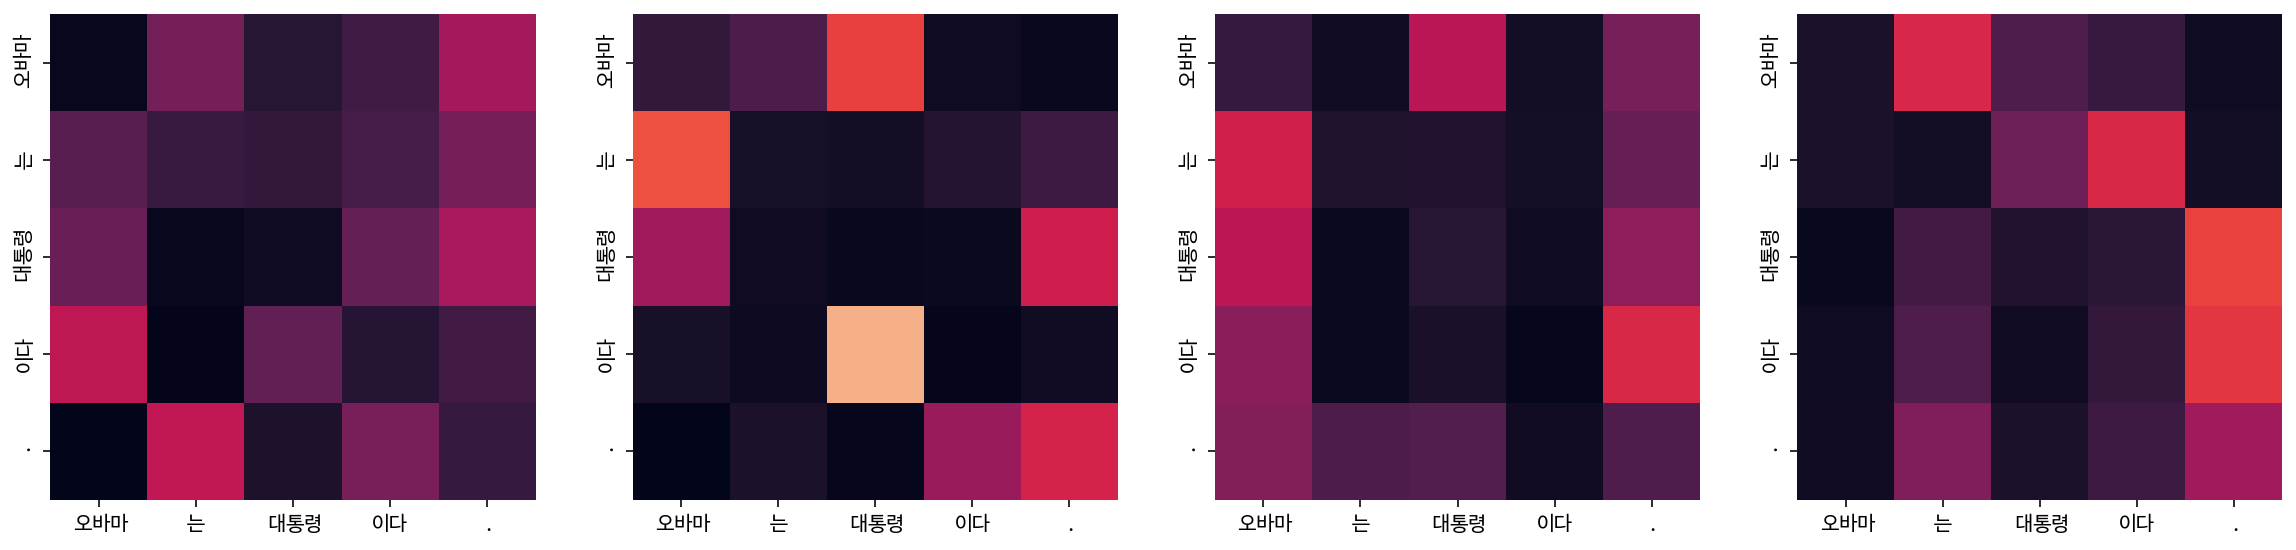

Encoder Layer 2


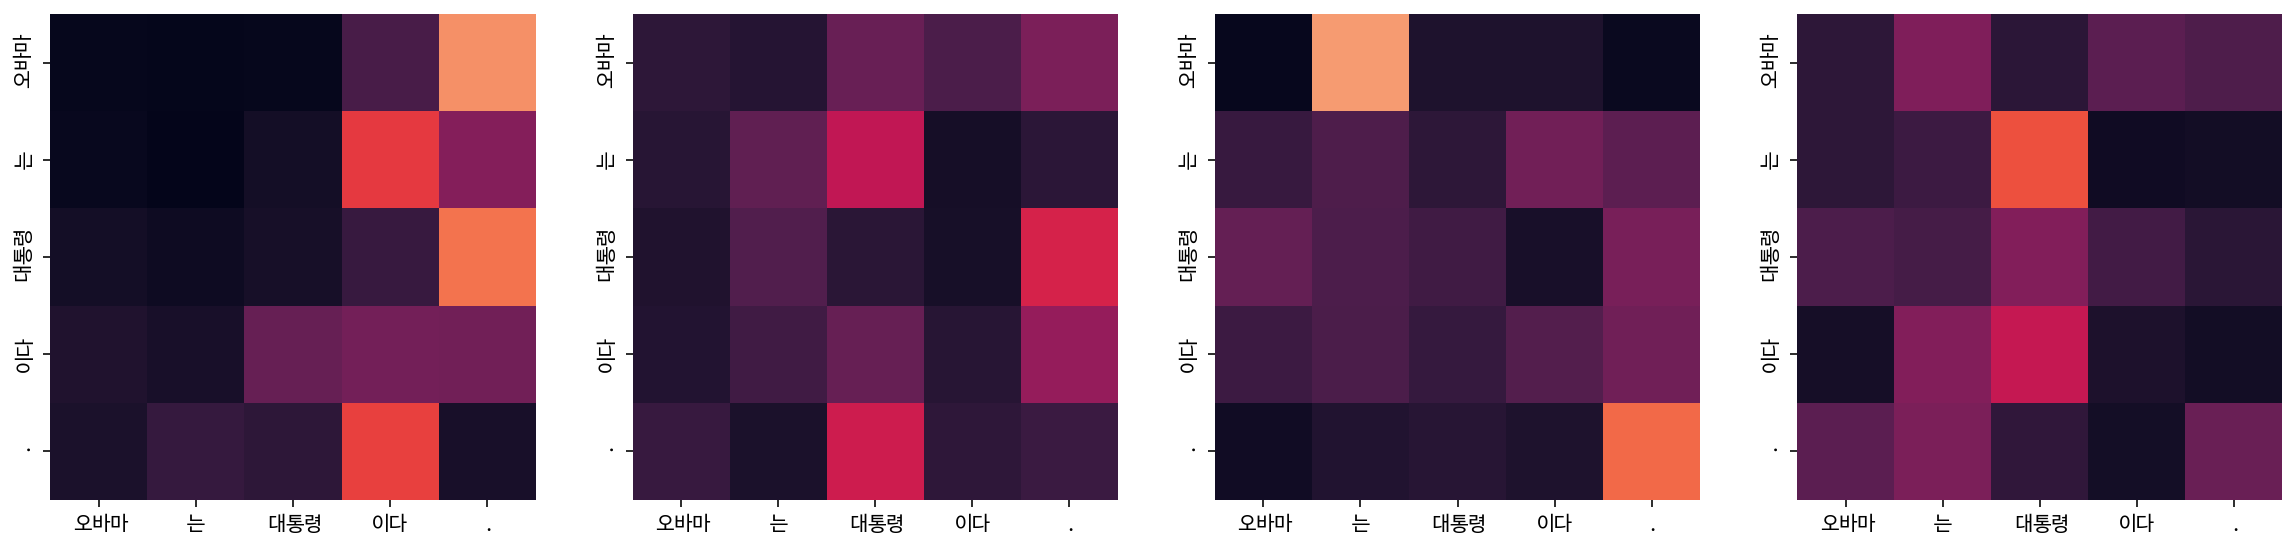

Decoder Self Layer 1


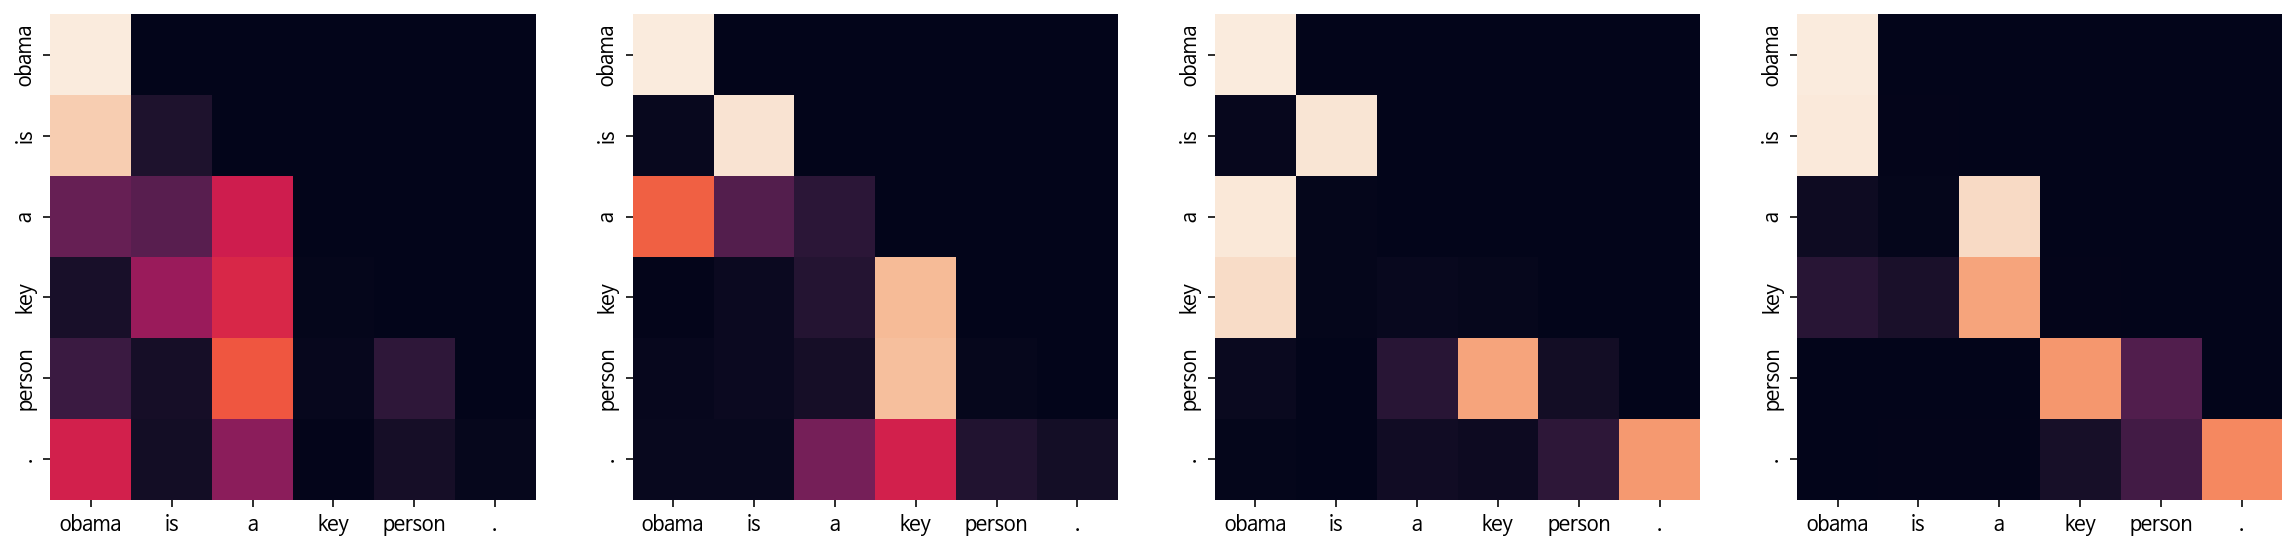

Decoder Src Layer 1


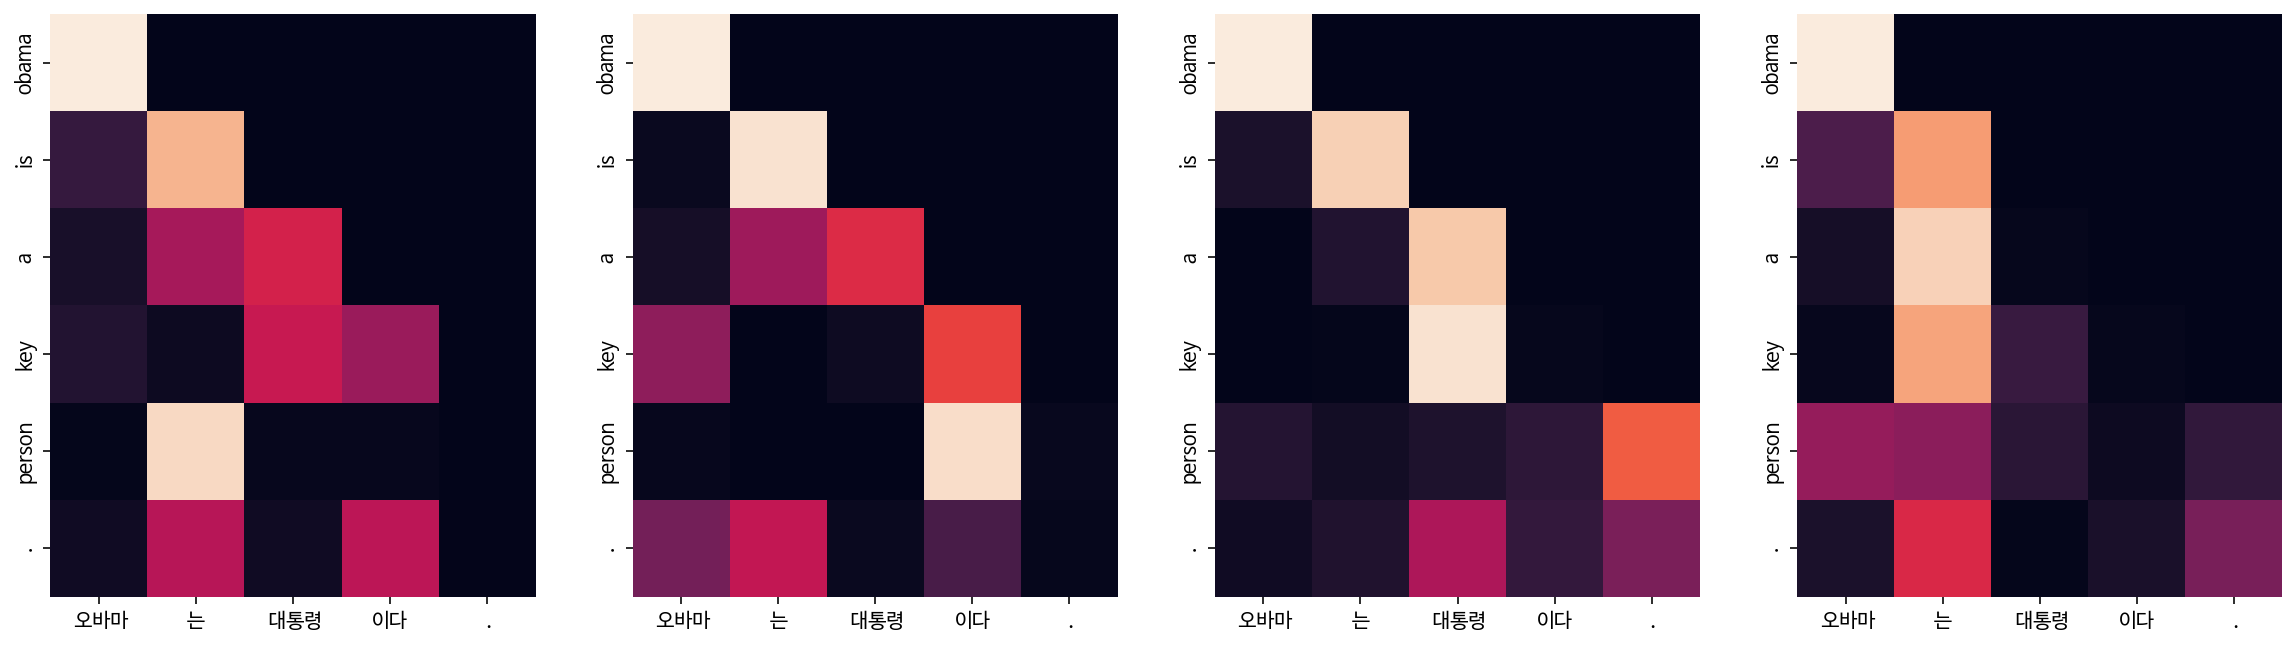

Decoder Self Layer 2


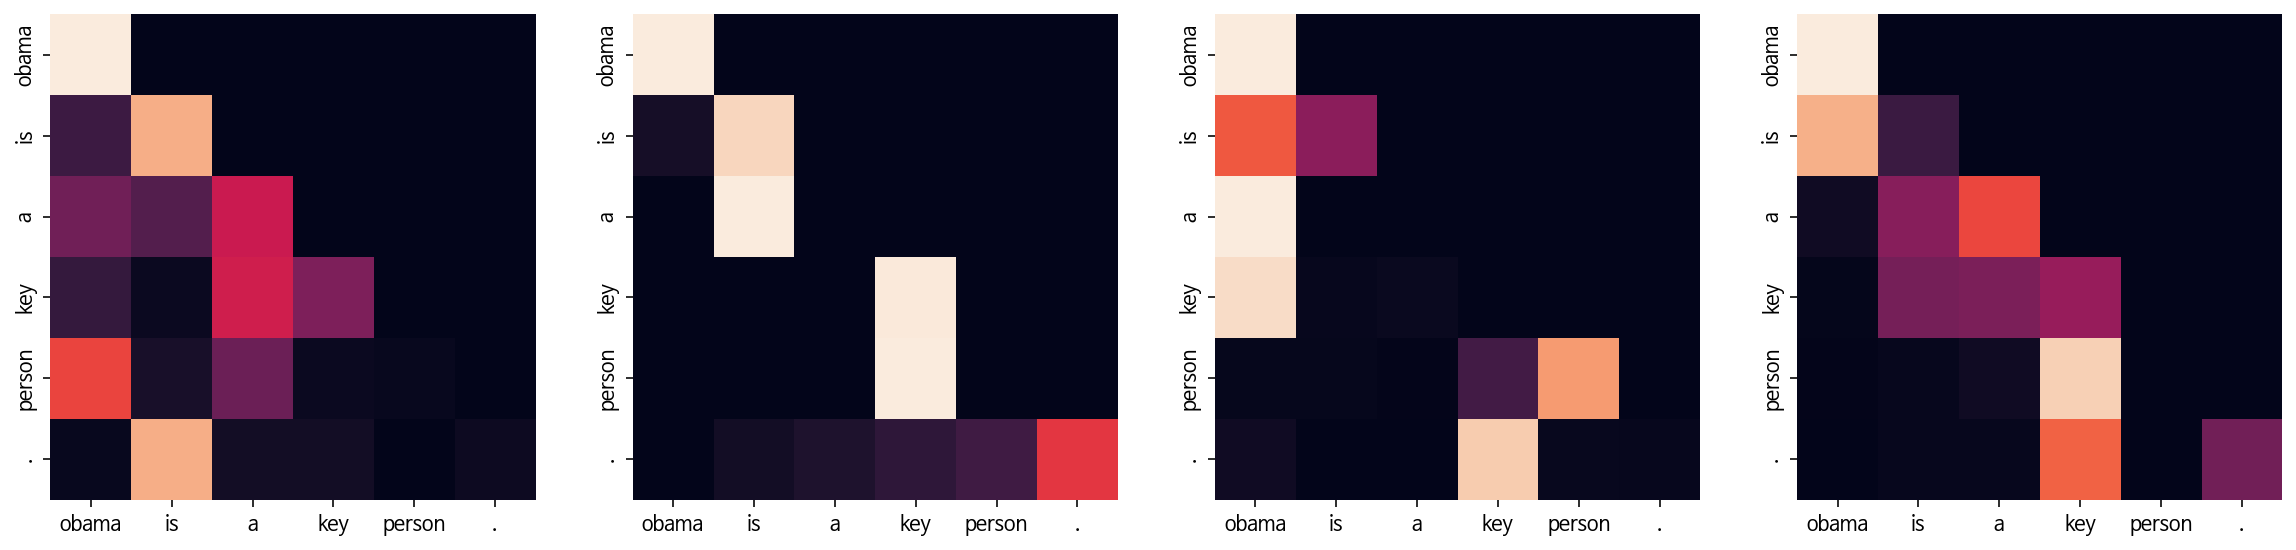

Decoder Src Layer 2


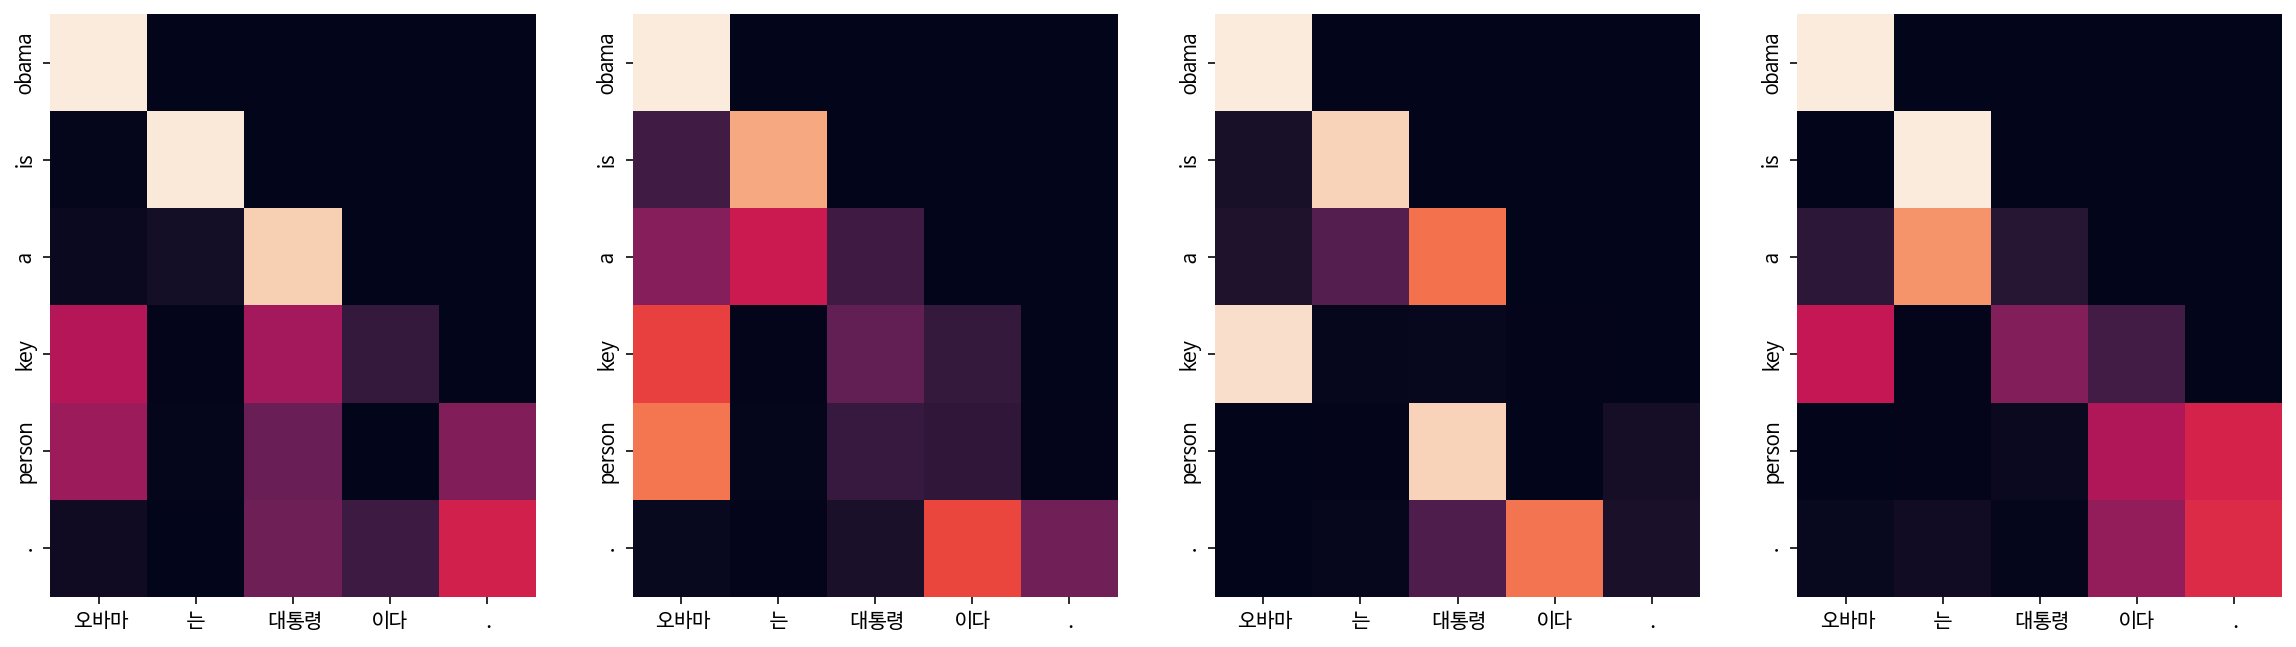

Input: 시민들은 도시 속에 산다.
Predicted translation: it is on a bus in town .
Encoder Layer 1


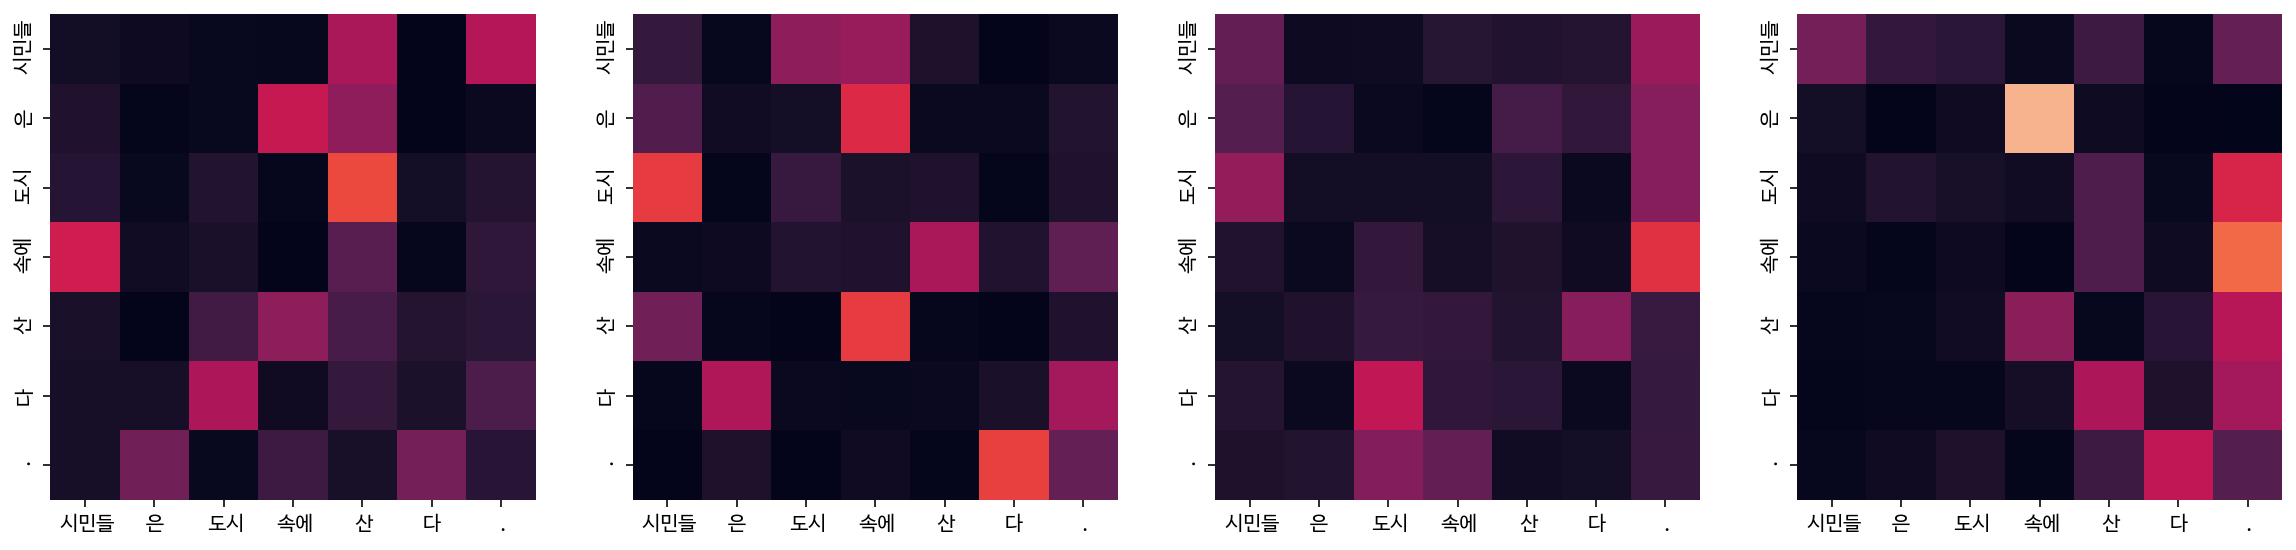

Encoder Layer 2


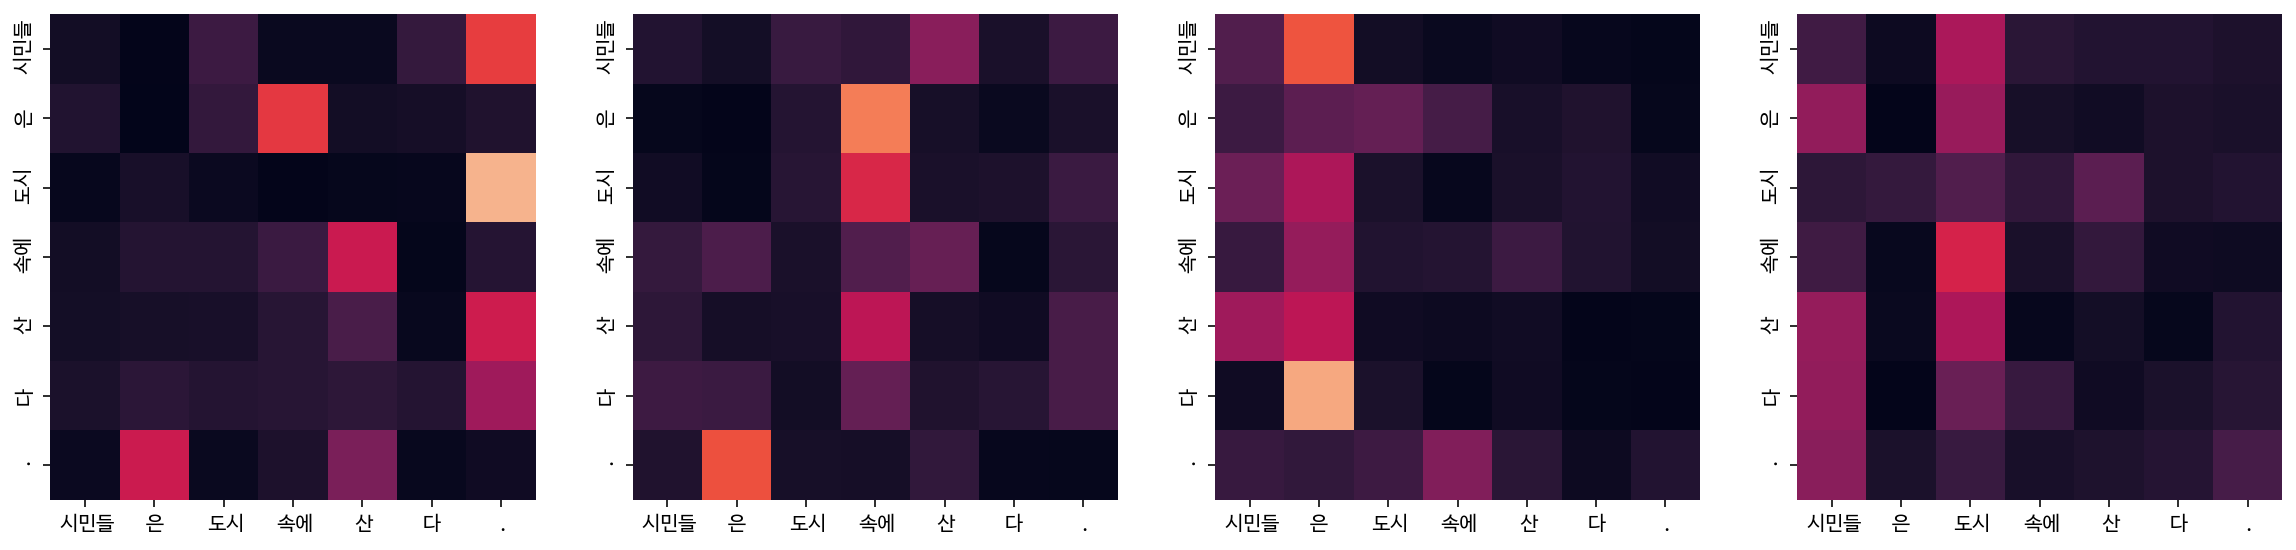

Decoder Self Layer 1


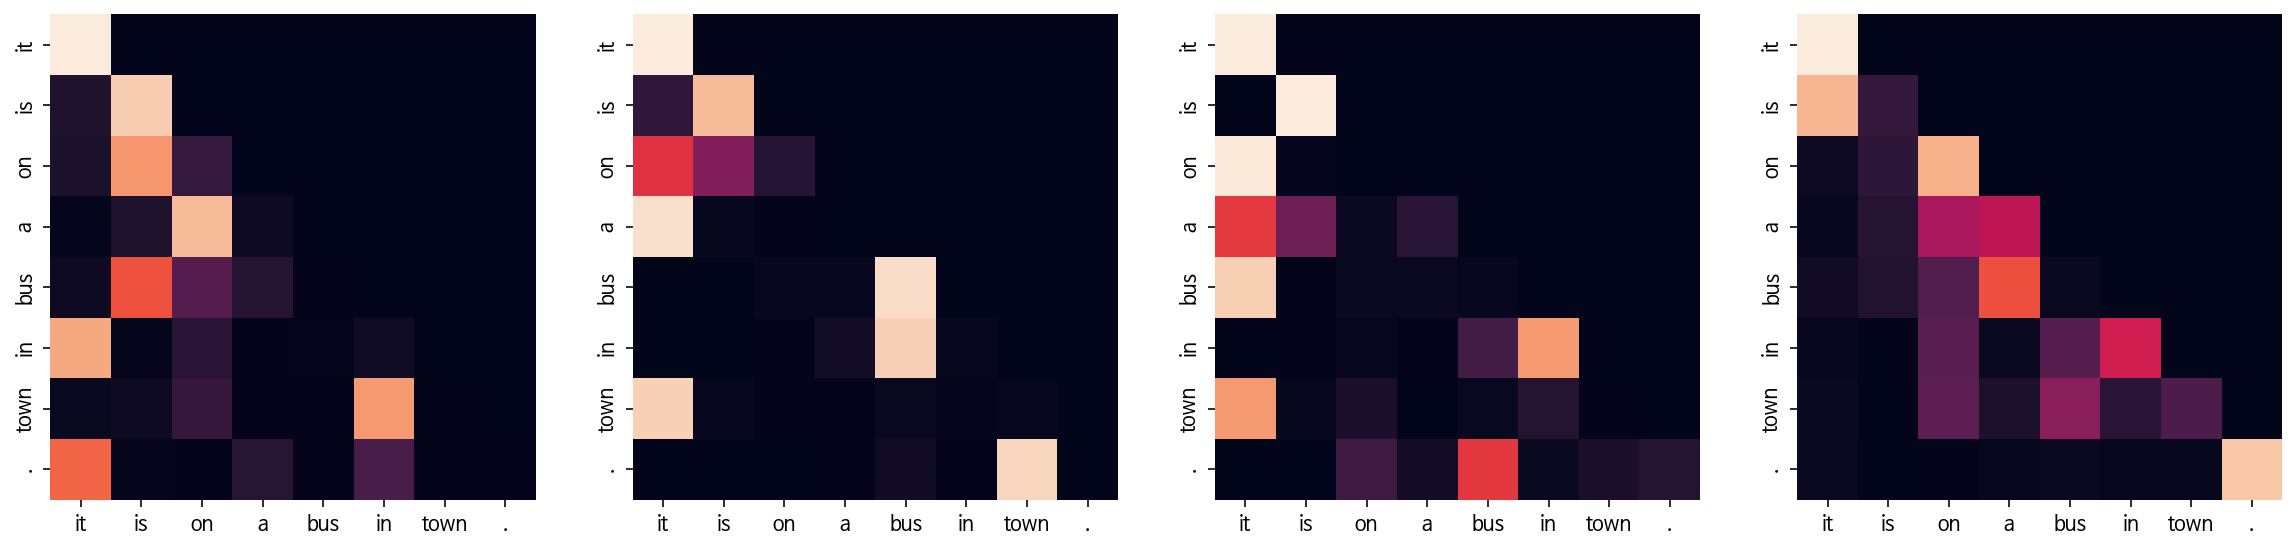

Decoder Src Layer 1


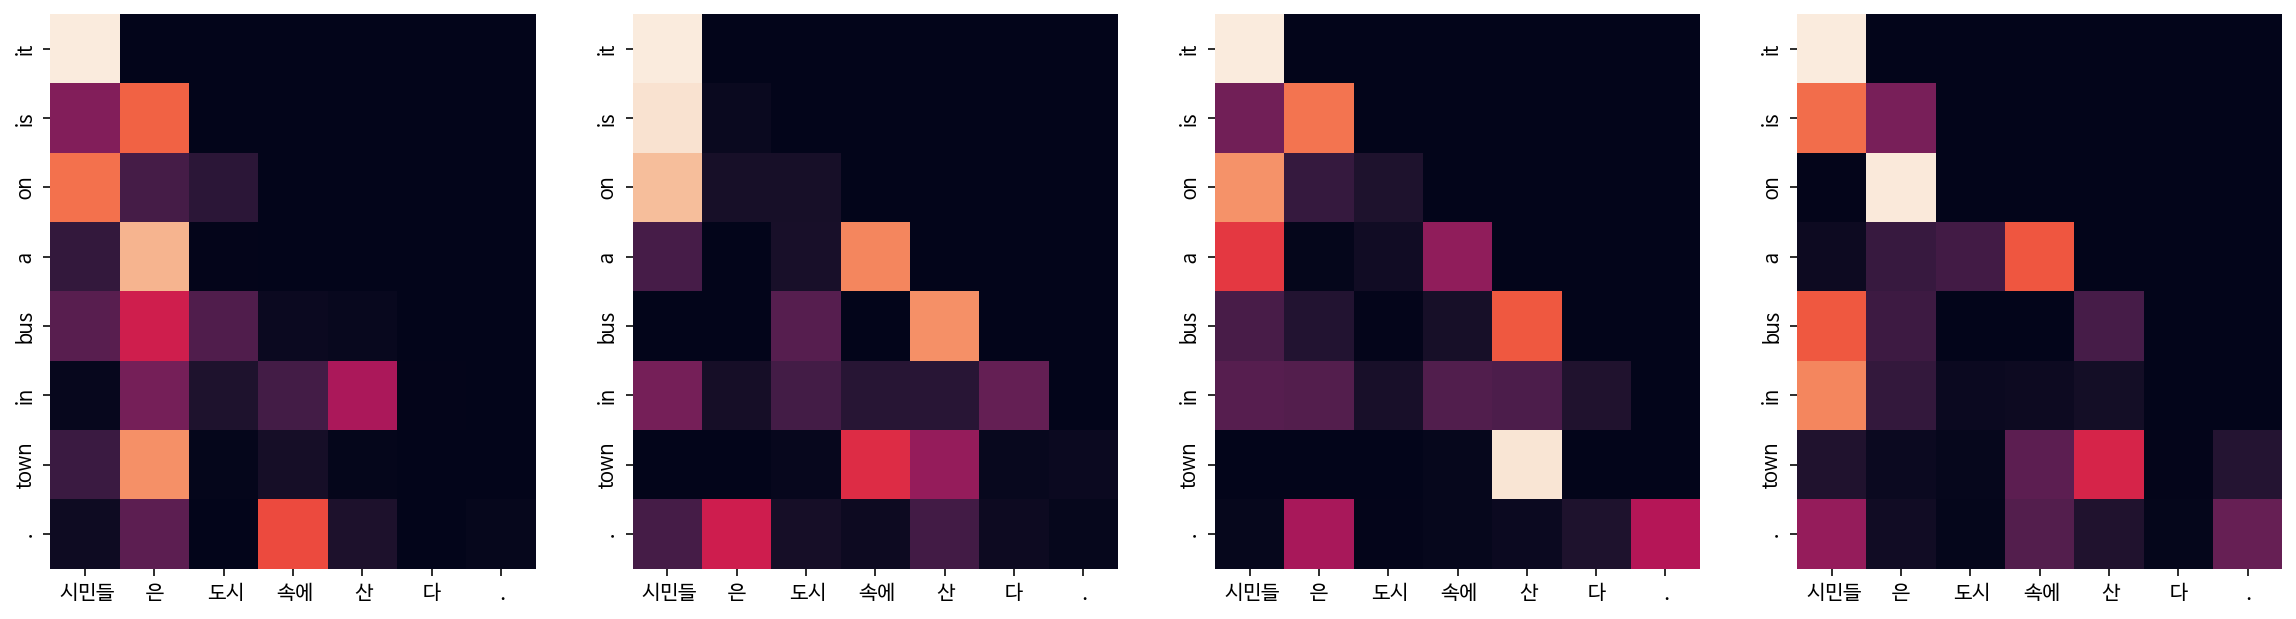

Decoder Self Layer 2


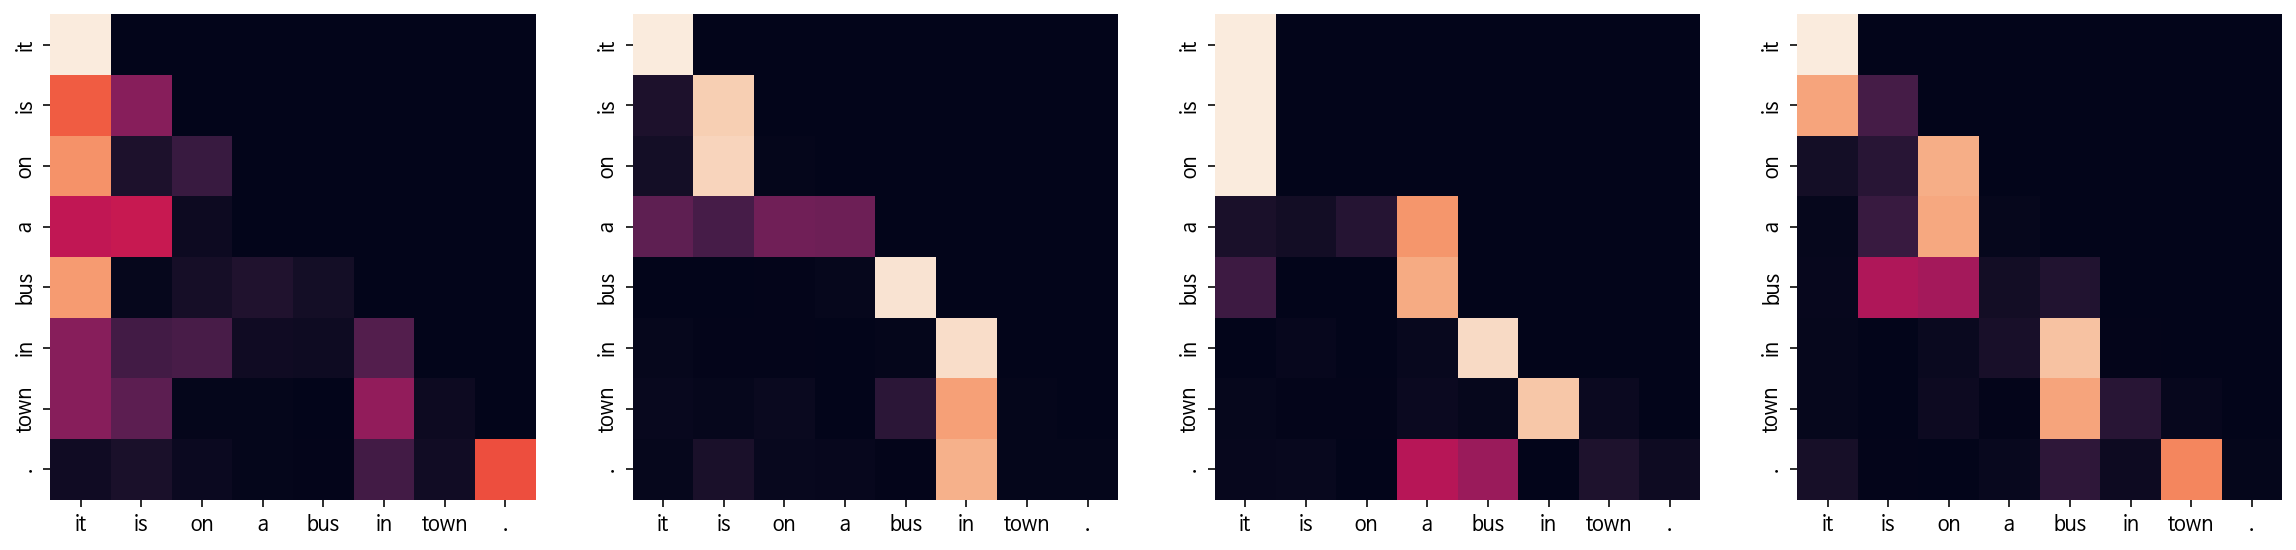

Decoder Src Layer 2


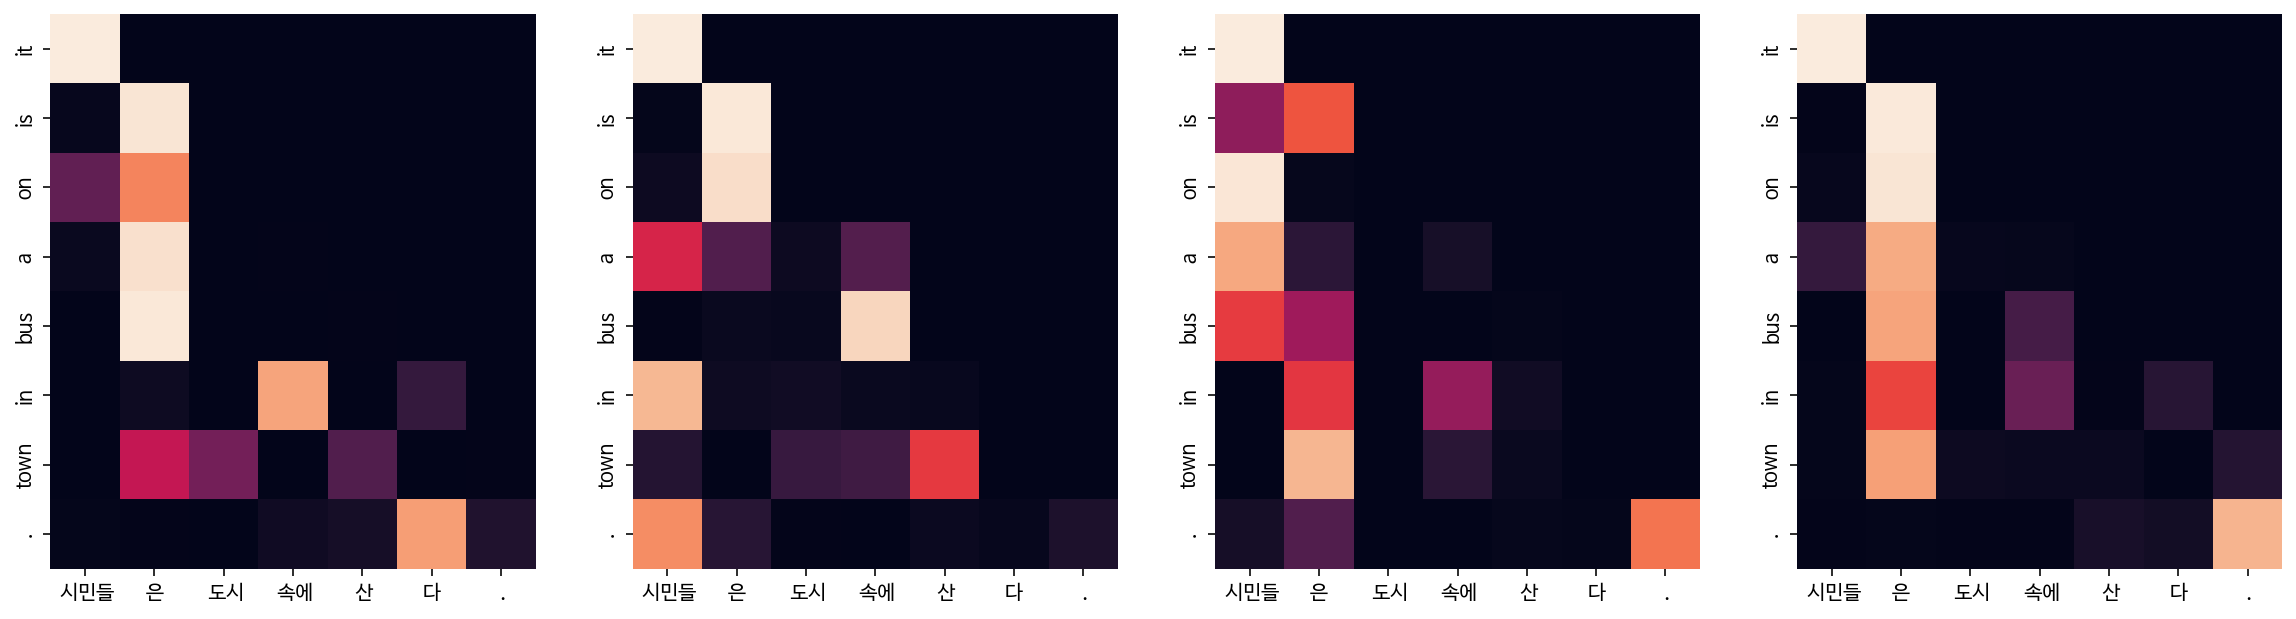

Input: 커피는 필요 없다.
Predicted translation: coffee is needed .
Encoder Layer 1


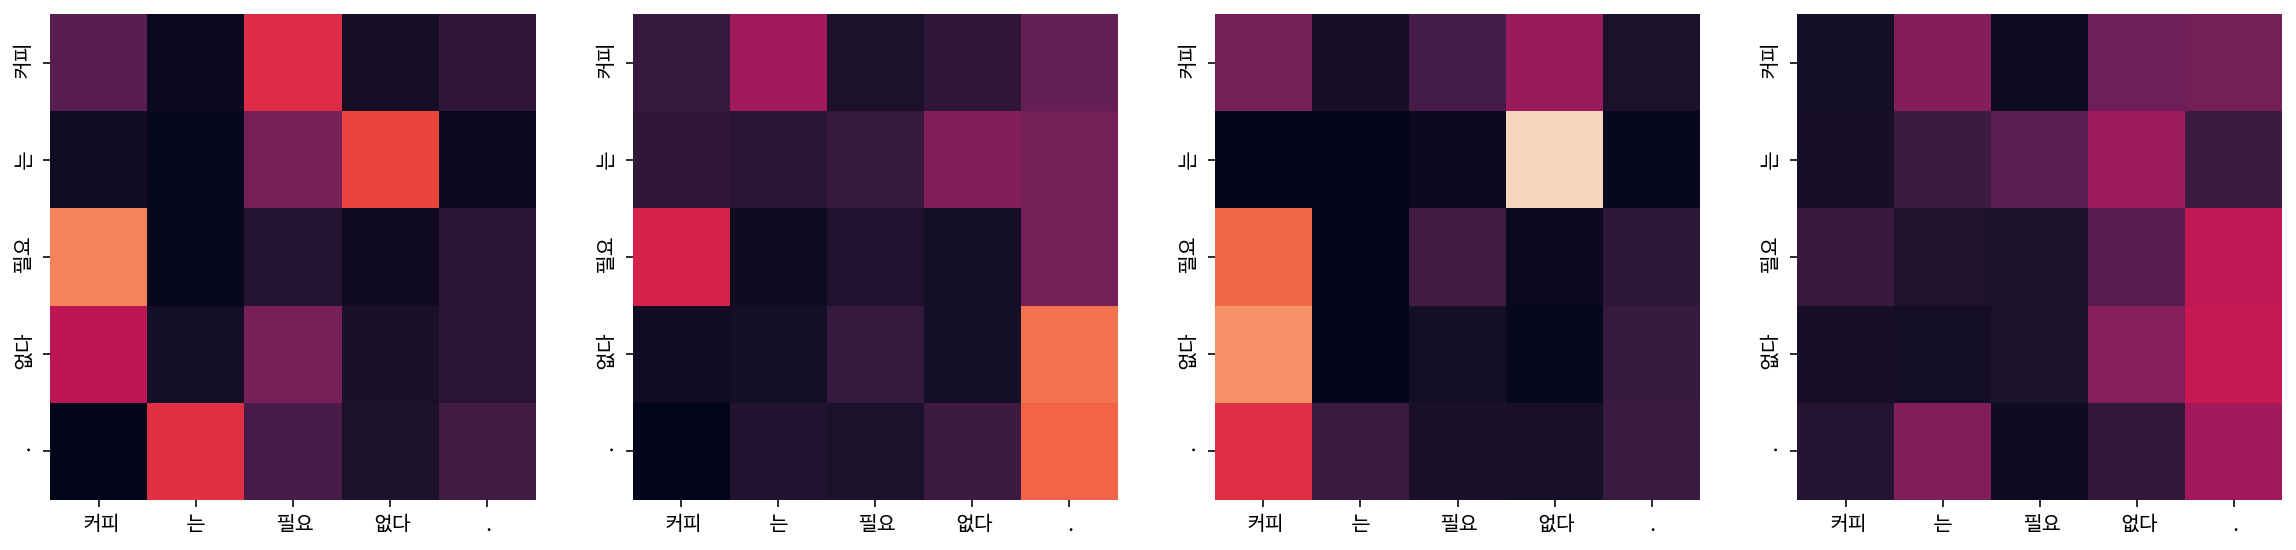

Encoder Layer 2


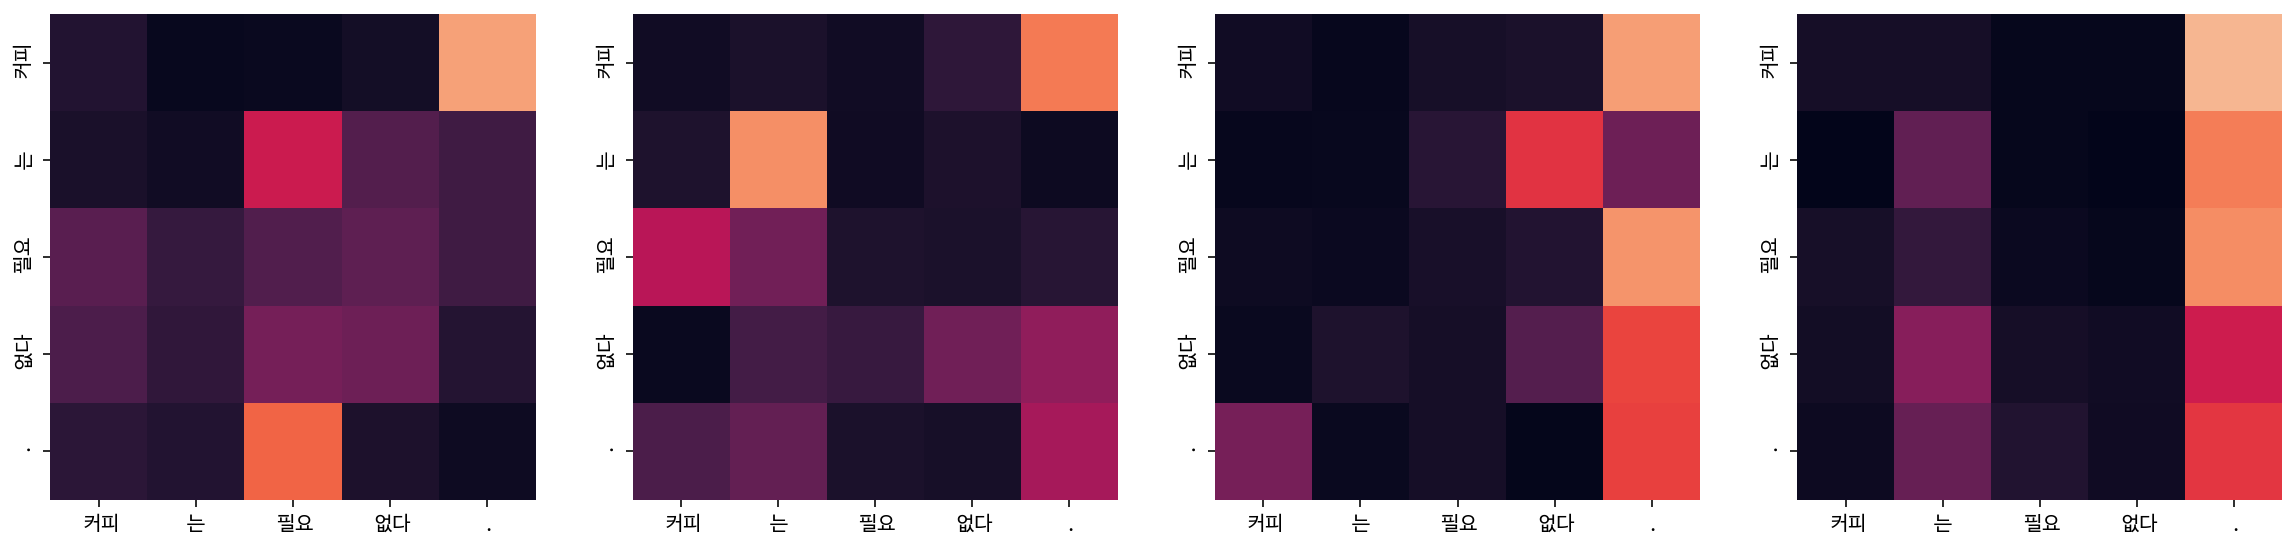

Decoder Self Layer 1


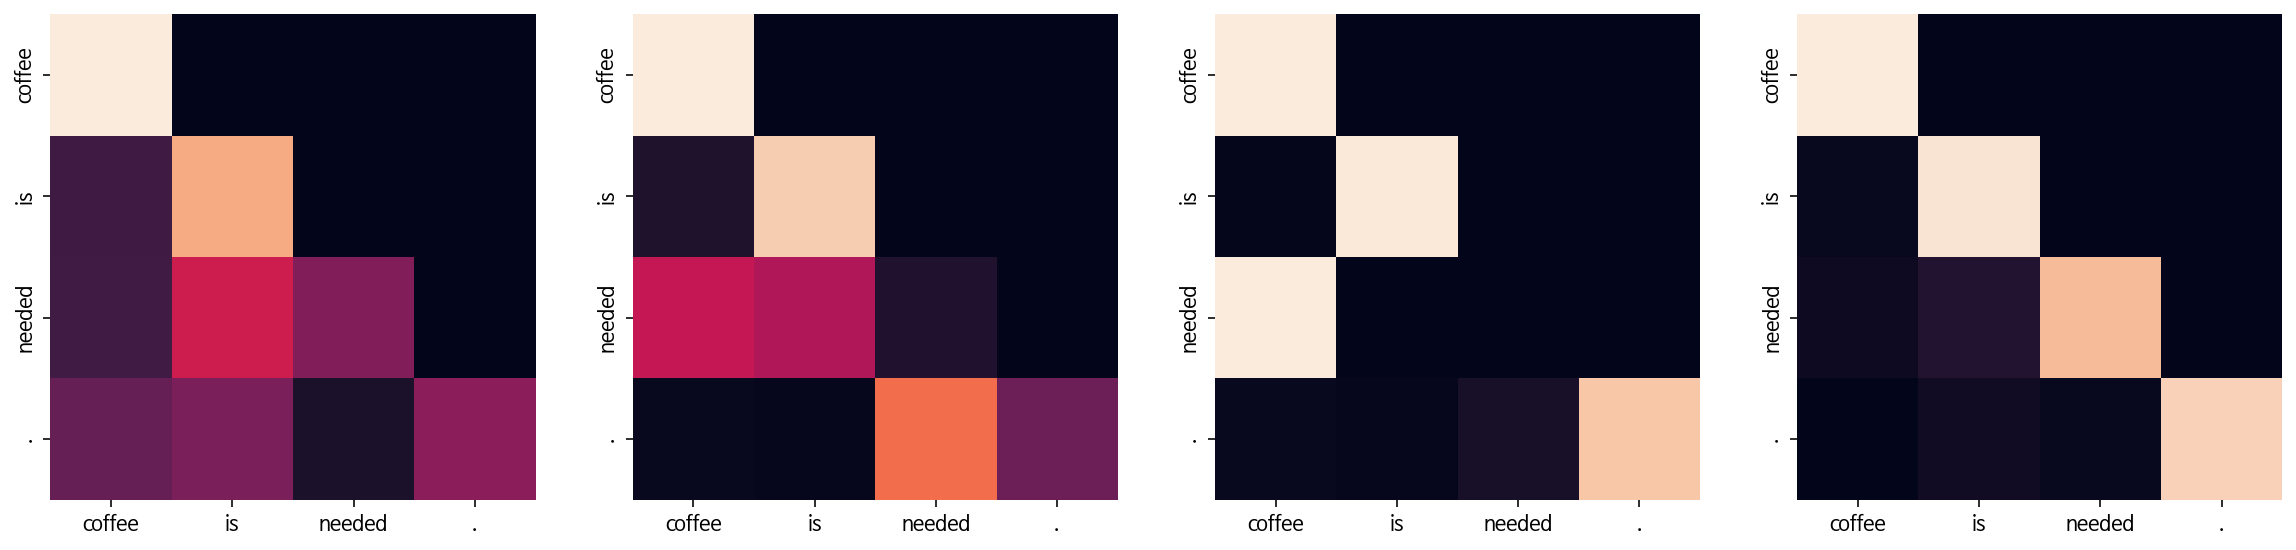

Decoder Src Layer 1


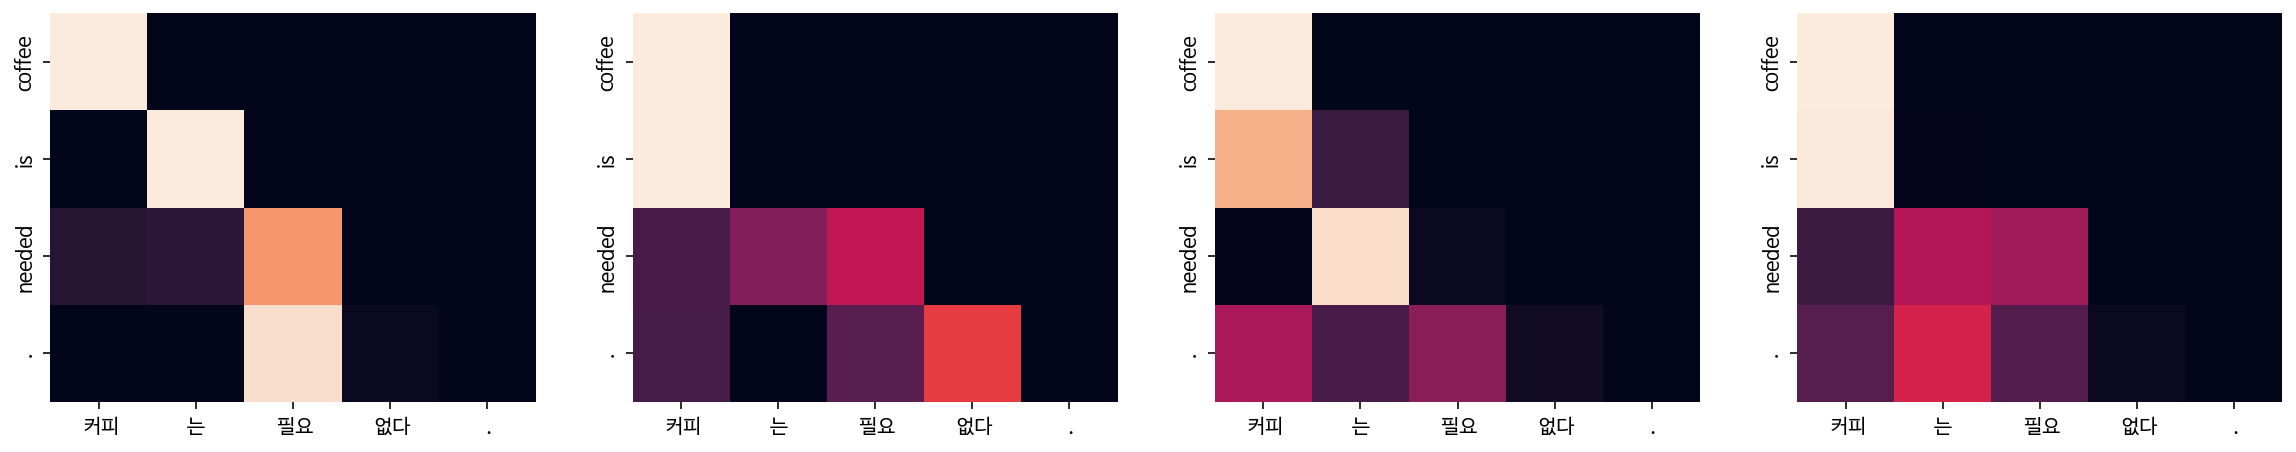

Decoder Self Layer 2


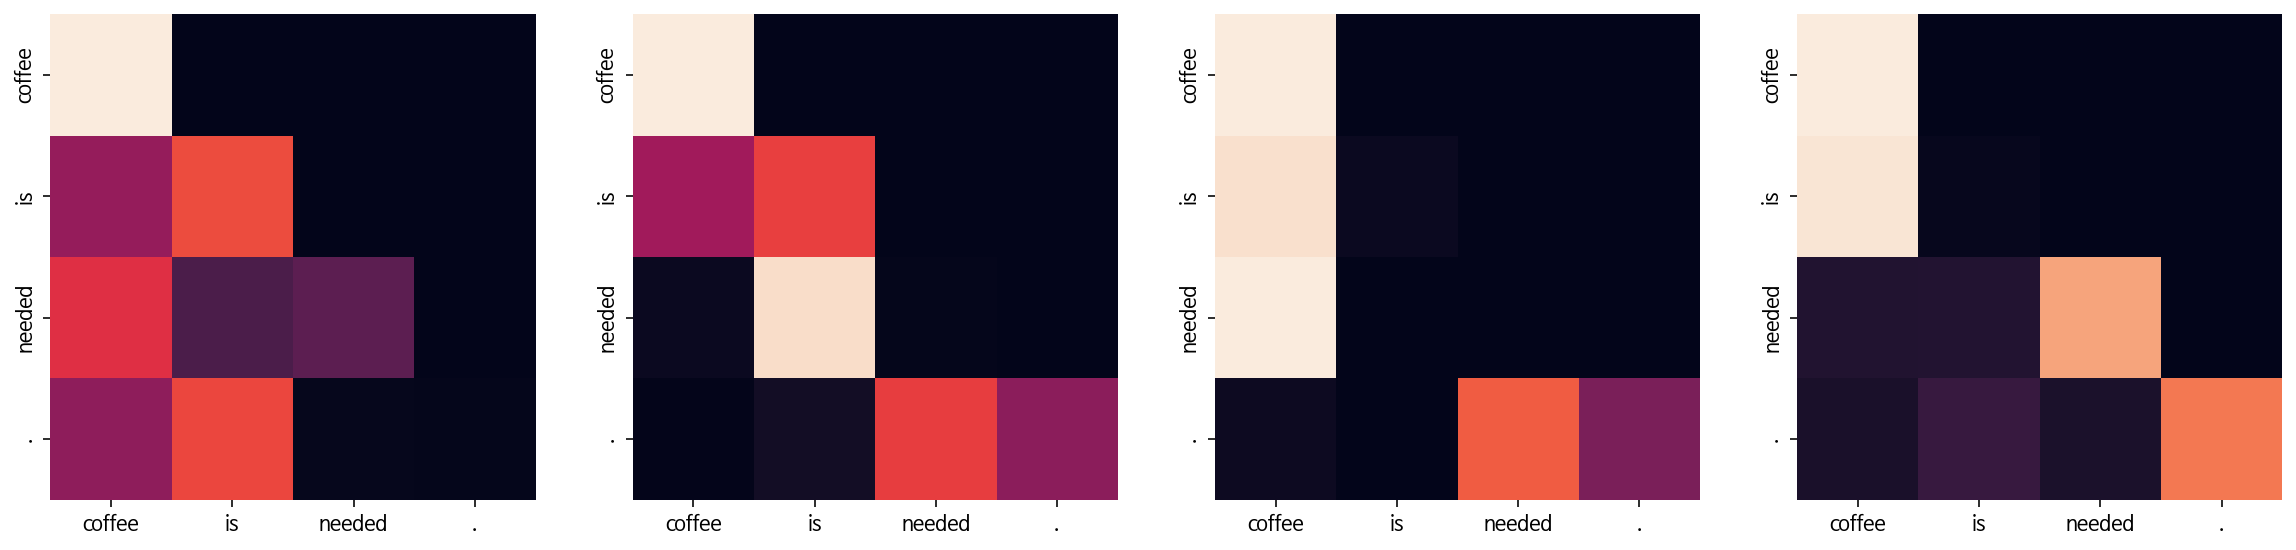

Decoder Src Layer 2


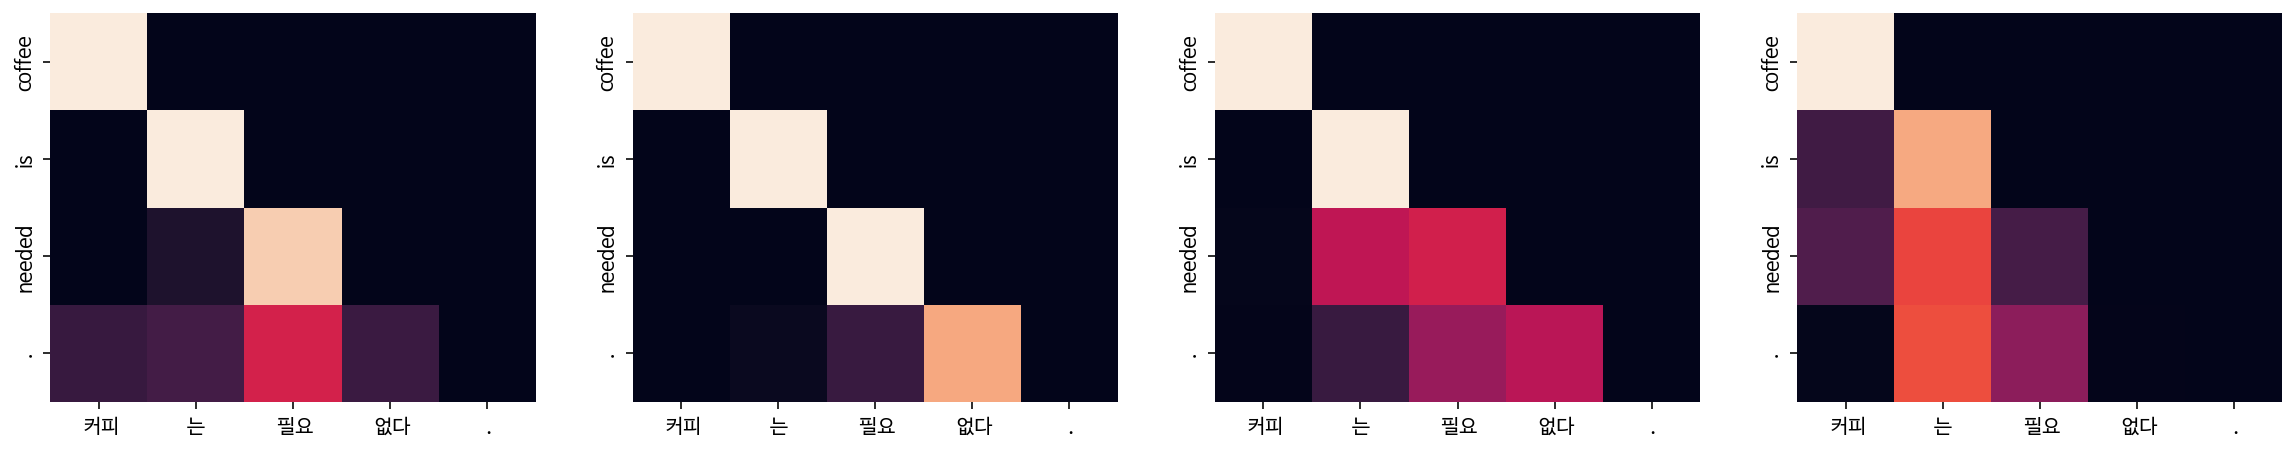

Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people died at the ministry .
Encoder Layer 1


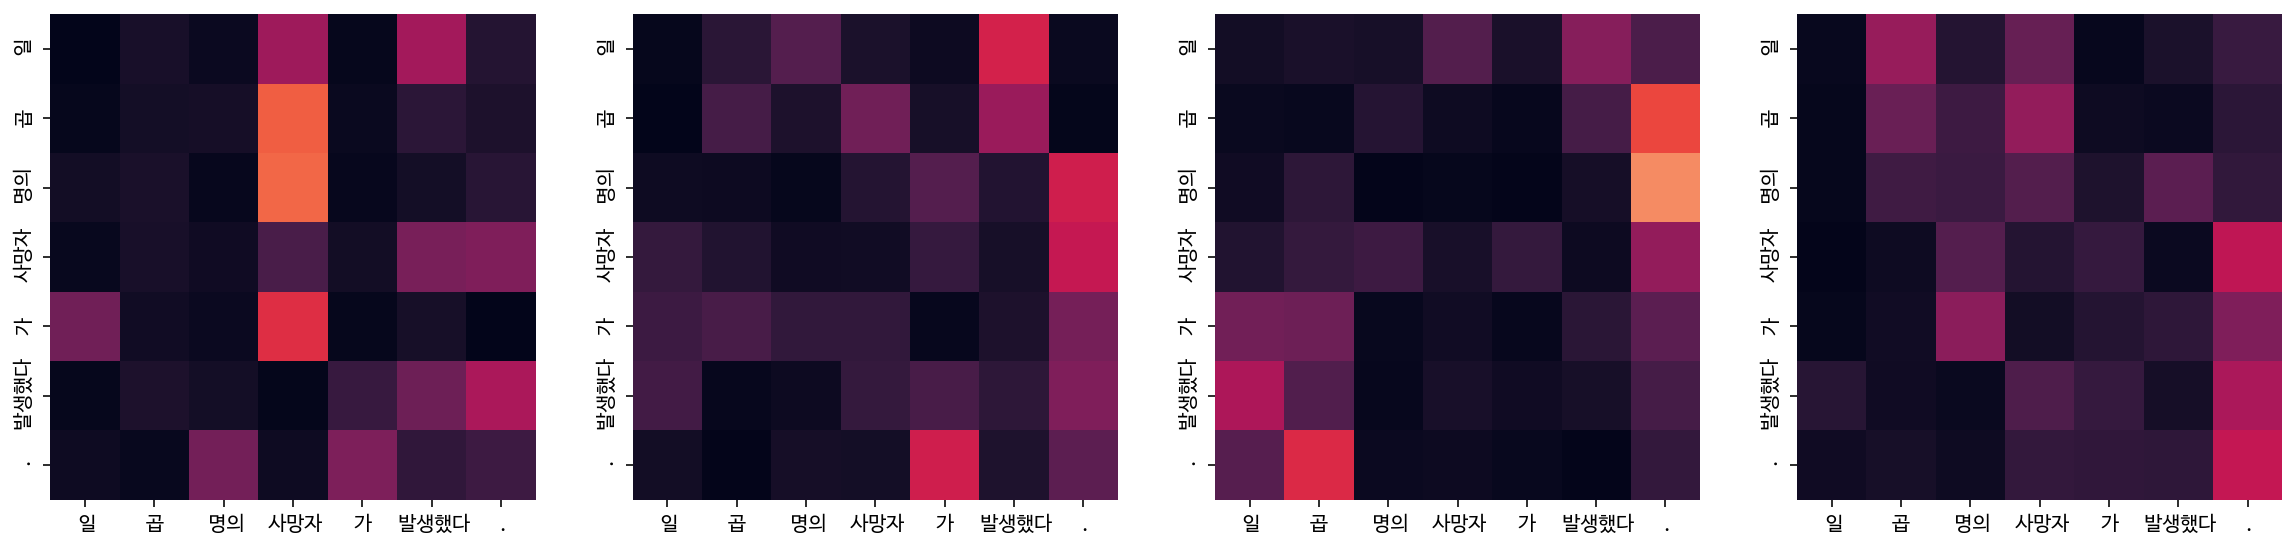

Encoder Layer 2


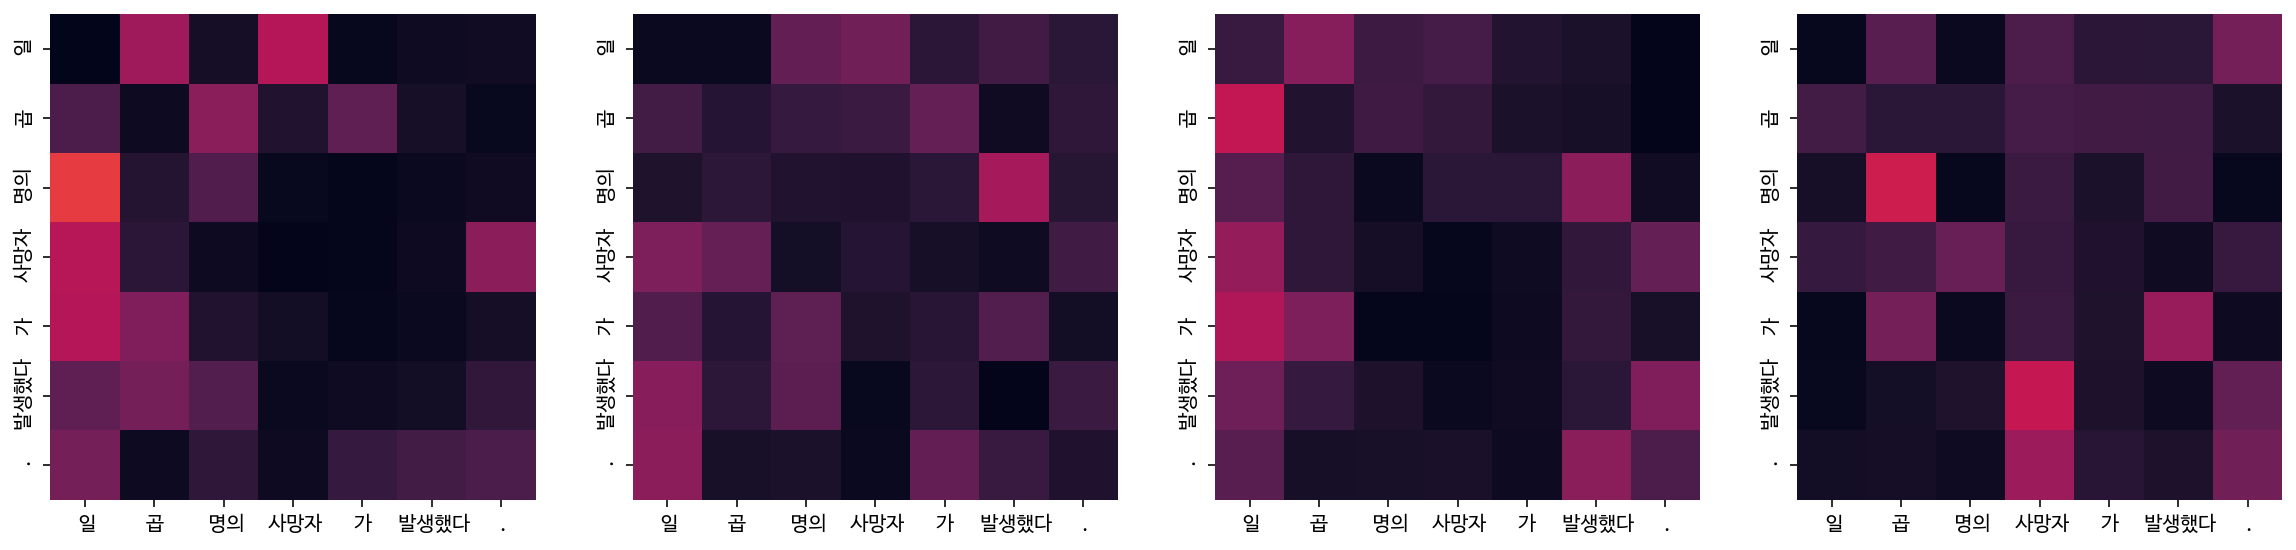

Decoder Self Layer 1


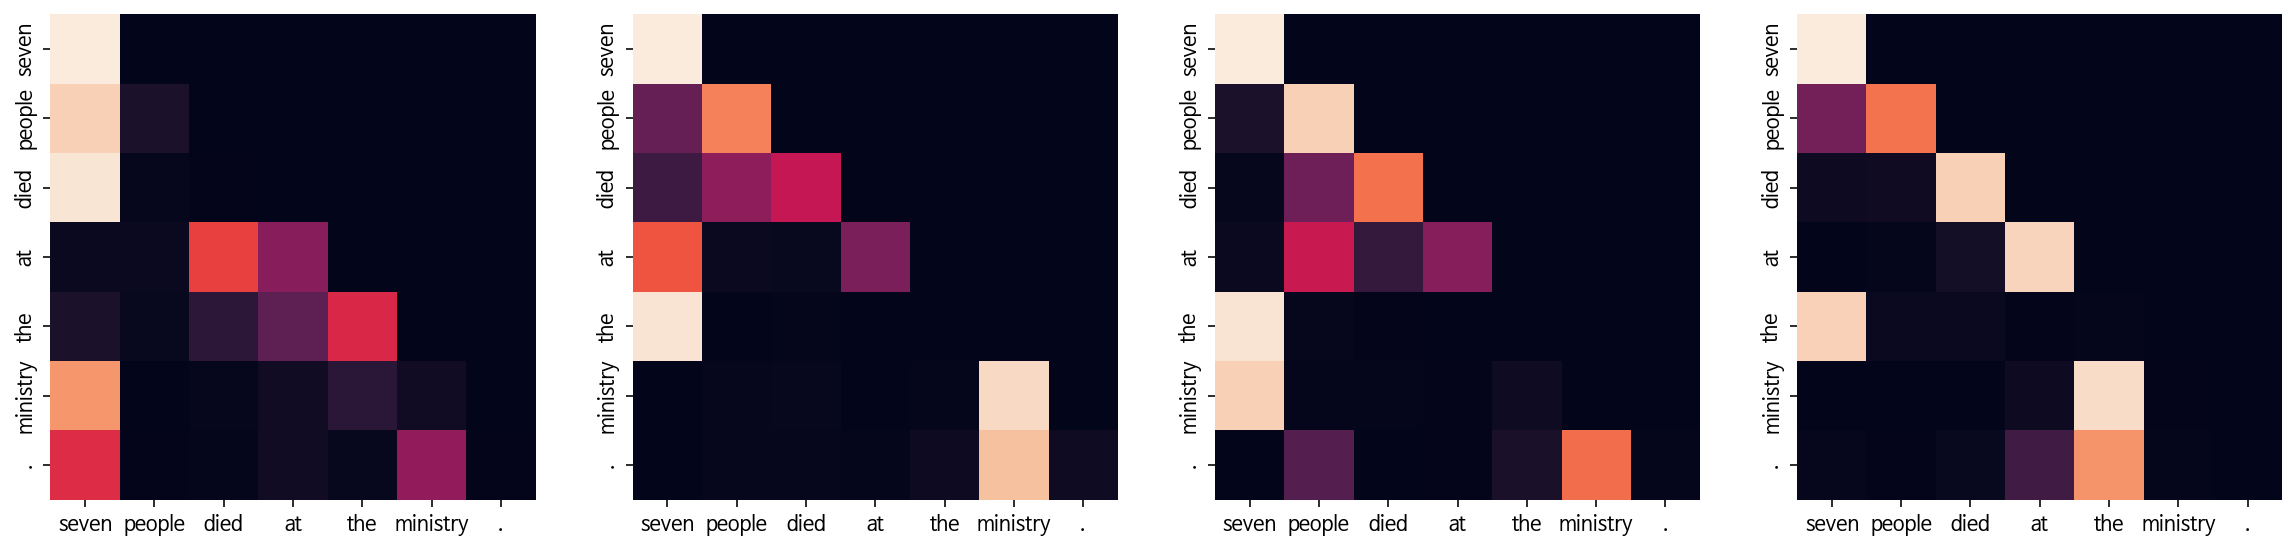

Decoder Src Layer 1


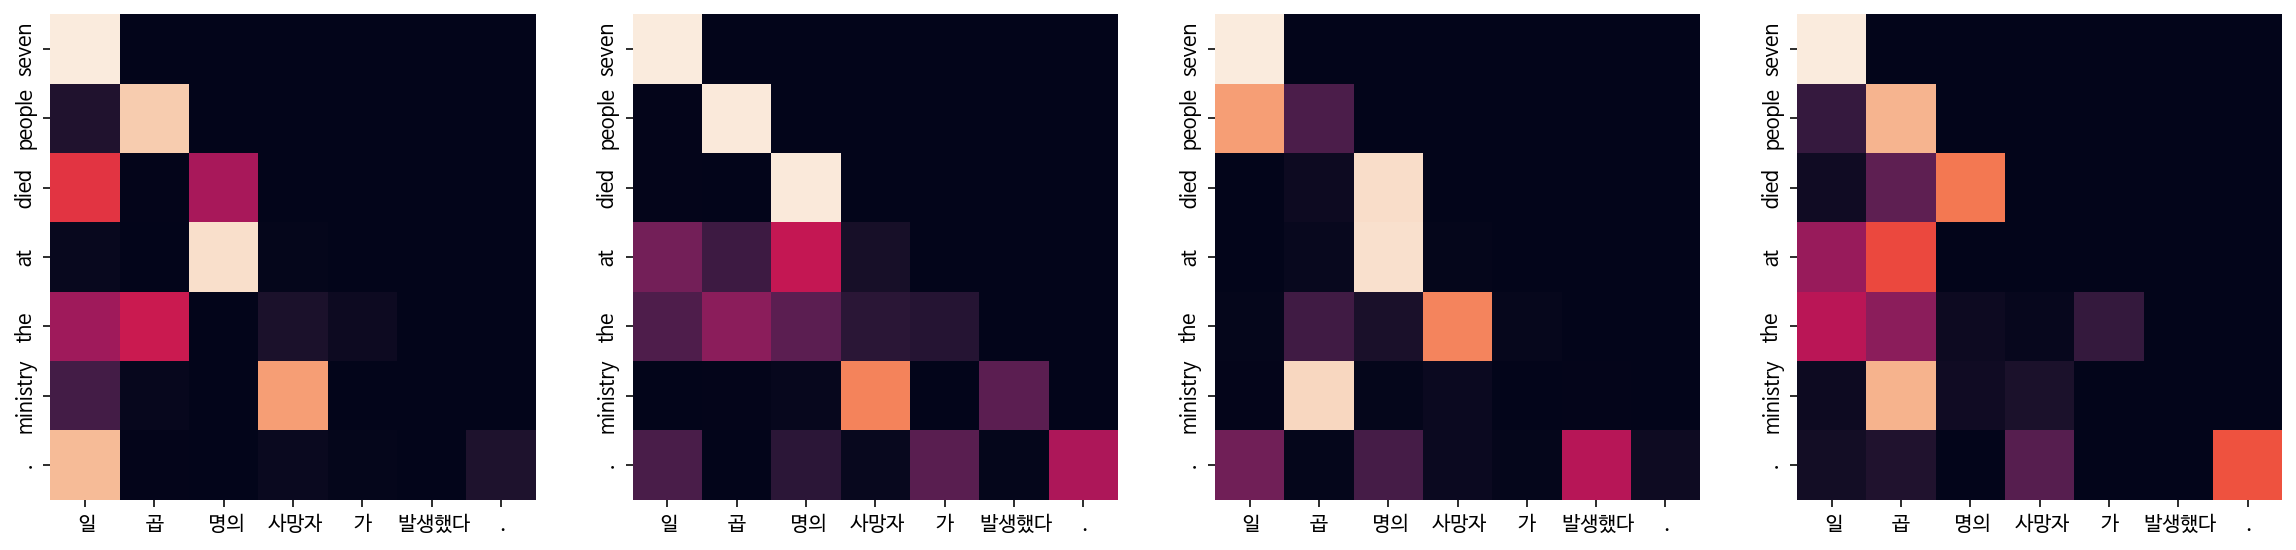

Decoder Self Layer 2


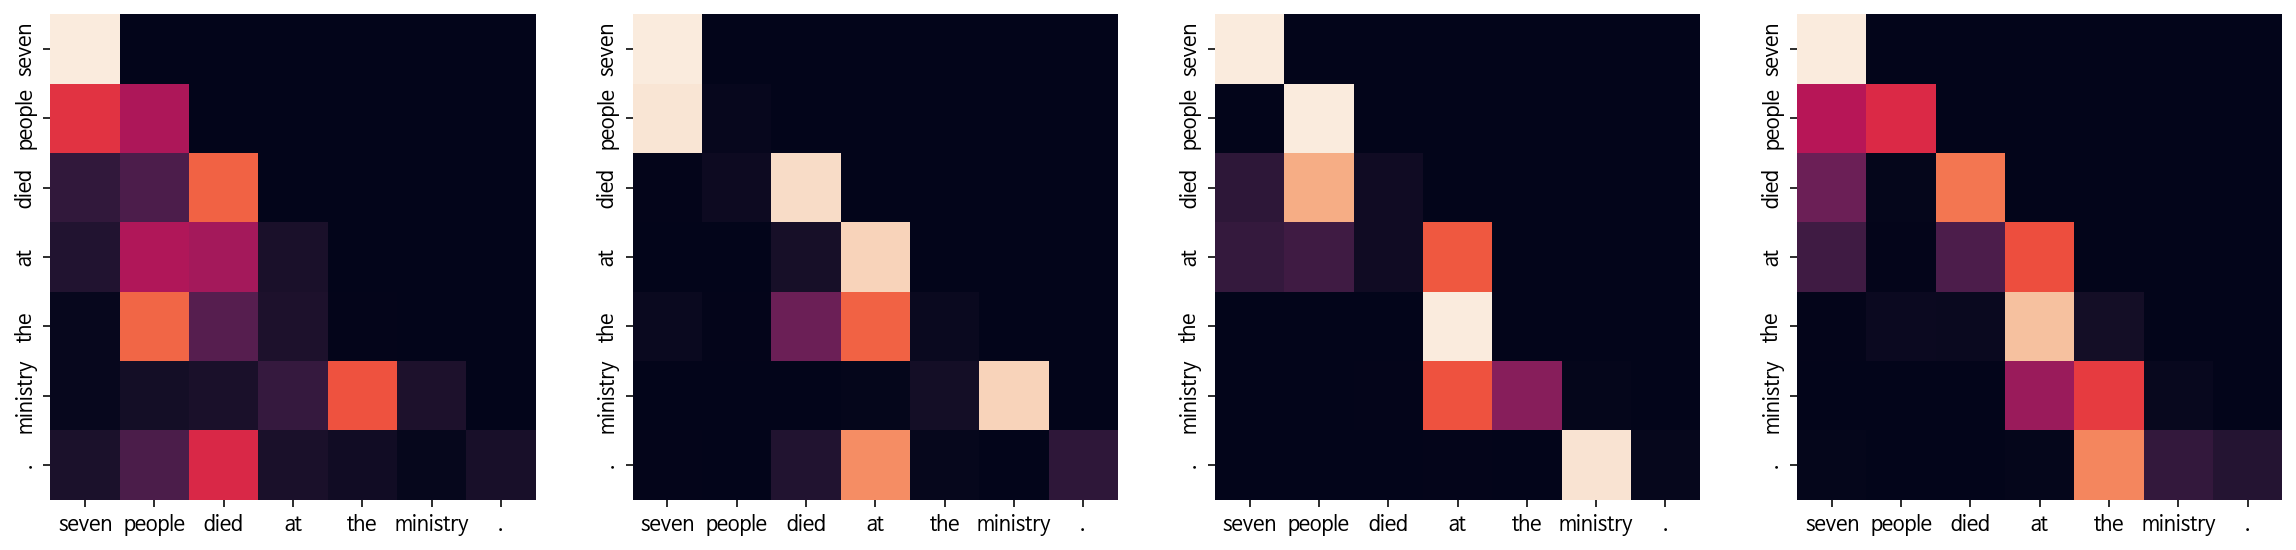

Decoder Src Layer 2


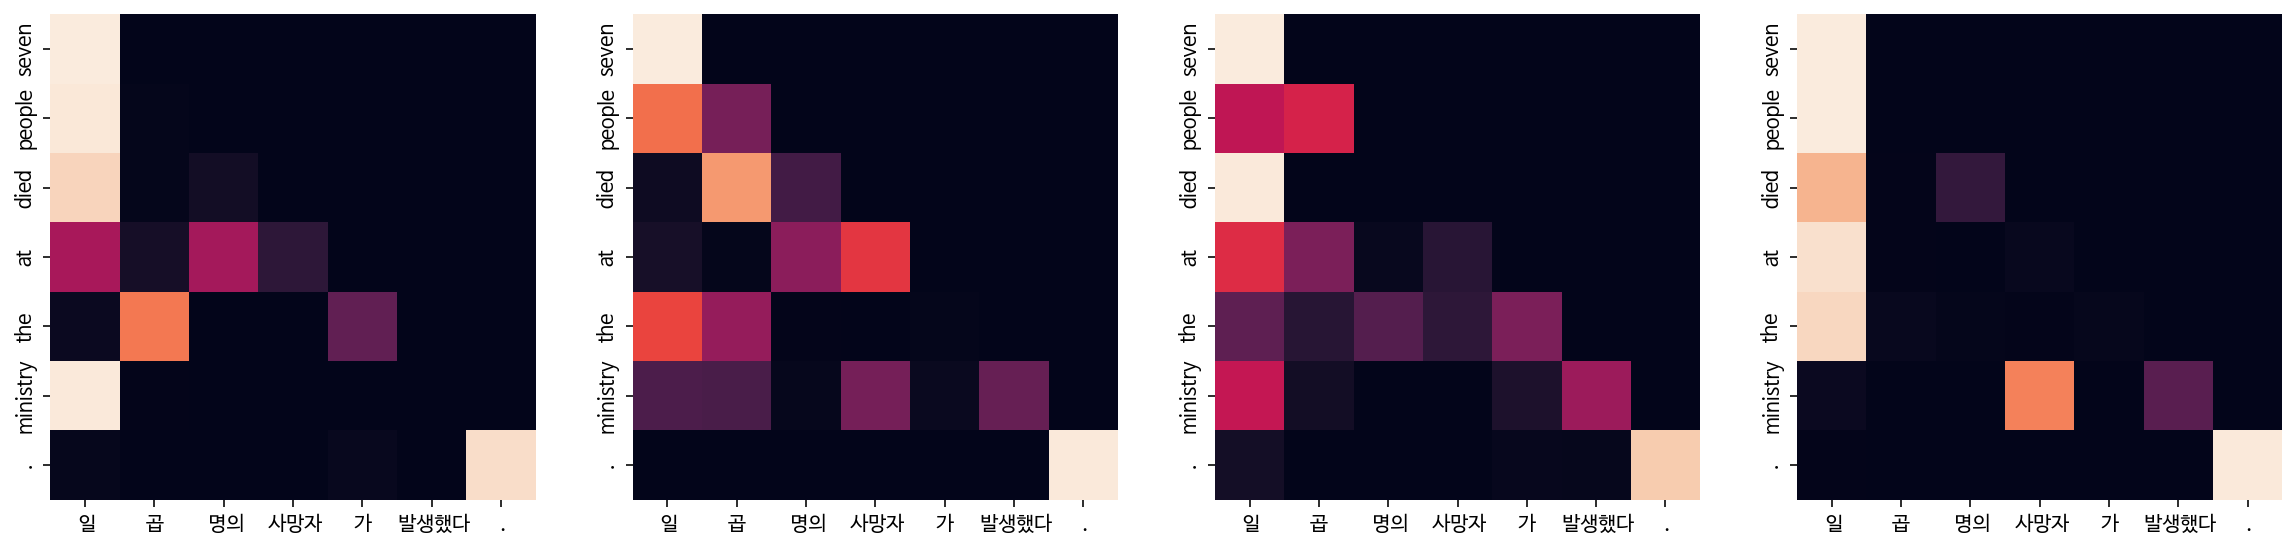

In [41]:
for example in examples:
        translate(example, transformer, ko_tokenizer, en_tokenizer, True)

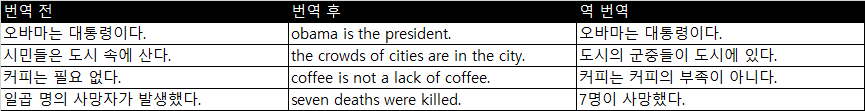

에포크 3번 째에 꽤 괜찮은 번역이 이루어졌다.

# 6. 회고하기

어텐션만을 이용했을 때는 오바마라는 단어 조차도 나오지 않았는데  
트랜스포머를 쓰니 훨씬 더 만족스러운 결과를 얻었다.  
물론 전처리도 더 강하게 하고 센텐스피스 토크나이저를 써서 잘나온 이유도 있는 것 같다.